In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessorV2

%matplotlib inline

In [186]:
print(region_info)

[('Albania', 'AL', 'ALB'), ('Andorra', 'AD', 'AND'), ('Austria', 'AT', 'AUT'), ('Belgium', 'BE', 'BEL'), ('Bosnia and Herzegovina', 'BA', 'BIH'), ('Bulgaria', 'BG', 'BGR'), ('Croatia', 'HR', 'HRV'), ('Czech Republic', 'CZ', 'CZE'), ('Denmark', 'DK', 'DNK'), ('Estonia', 'EE', 'EST'), ('Finland', 'FI', 'FIN'), ('France', 'FR', 'FRA'), ('Germany', 'DE', 'DEU'), ('Greece', 'GR', 'GRC'), ('Hungary', 'HU', 'HUN'), ('Iceland', 'IS', 'ISL'), ('Ireland', 'IE', 'IRL'), ('Israel', 'IL', 'ISR'), ('Italy', 'IT', 'ITA'), ('Malaysia', 'MY', 'MYS'), ('Mexico', 'MX', 'MEX'), ('Morocco', 'MA', 'MAR'), ('Netherlands', 'NL', 'NLD'), ('New Zealand', 'NZ', 'NZL'), ('Norway', 'NO', 'NOR'), ('Poland', 'PL', 'POL'), ('Portugal', 'PT', 'PRT'), ('Romania', 'RO', 'ROU'), ('Serbia', 'RS', 'SRB'), ('Singapore', 'SG', 'SGP'), ('Slovakia', 'SK', 'SVK'), ('Slovenia', 'SI', 'SVN'), ('South Africa', 'ZA', 'ZAF'), ('South Korea', 'KR', 'KOR'), ('Spain', 'ES', 'ESP'), ('Sweden', 'SE', 'SWE'), ('Switzerland', 'CH', 'CHE'),

In [257]:
# name, epidemicforecasting.org code, OxCGRT code
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ('Albania','AL','ALB'),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
#      ('Georgia','GE','GEO'),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
#      ('Latvia','LV','LVA'),
#    ("South Korea", "KR", "KOR"),
#      ('Malta','MT','MLT'),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ('Norway','NO','NOR'),
    ('New Zealand','NZ','NZL'),
    ("Poland","PL", "POL"),
    ('Portugal','PT','PRT'),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF"),
]

region_info.sort(key=lambda x: x[0])

region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_oxcgrt = list([x for _, _, x in region_info])

# OxCGRT
oxcgrt_cm_cols = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
    ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
    ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
#     ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation',
 'Healthcare specialisation - limited',
 'Outgroup mobility',
 'General curfew',
 'Gatherings limited to 1000',    
 'Gatherings limited to 100',
 'Gatherings limited to 10',
 'Schools and universities closed'
]

ox_epi = {
    'Stay at Home, Req':'General curfew',
    'Gatherings lim. 1000':'Gatherings limited to 1000',
    'Gatherings lim. 100':'Gatherings limited to 100',
    'Gatherings lim. 10':'Gatherings limited to 10',
    'All Schools Closed':'Schools and universities closed'
}

# ox_epi = dict()

final_features_ordered = [
    "Healthcare specialisation",
    'Healthcare specialisation - limited',
    "Symptomatic Testing",
    "Public Testing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    "Gatherings lim. 1000",    
    "Gatherings lim. 100",
    "Gatherings lim. 10",
    "All Schools Closed",
    "Stay at Home, Req"
]

nCMs = len(final_features_ordered)

dp = DataPreprocessorV2(min_num_confirmed_mask=100, min_num_active_mask=100, start_date="2020-01-22", end_date="2020-04-20")

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: Epidemic Forecasting              min   ... mean  ... max   ... unique
 1 Mask wearing over 70%                      0.000 ... 0.063 ... 1.000 ... [0. 1.]
 2 Business suspended - some                  0.000 ... 0.285 ... 1.000 ... [0. 1.]
 3 Business suspended - many                  0.000 ... 0.208 ... 1.000 ... [0. 1.]
 4 Healthcare specialisation                  0.000 ... 0.072 ... 1.000 ... [0. 1.]
 5 Healthcare specialisation - limited        0.000 ... 0.105 ... 1.000 ... [0 1]
 6 Outgroup mobility                          0.000 ... 0.326 ... 1.000 ... [0. 1.]
 7 General curfew                             0.000 ... 0.150 ... 1.000 ... [0. 1.]
 8 Gatherings limited to 1000                 0.000 ... 0.320 ...

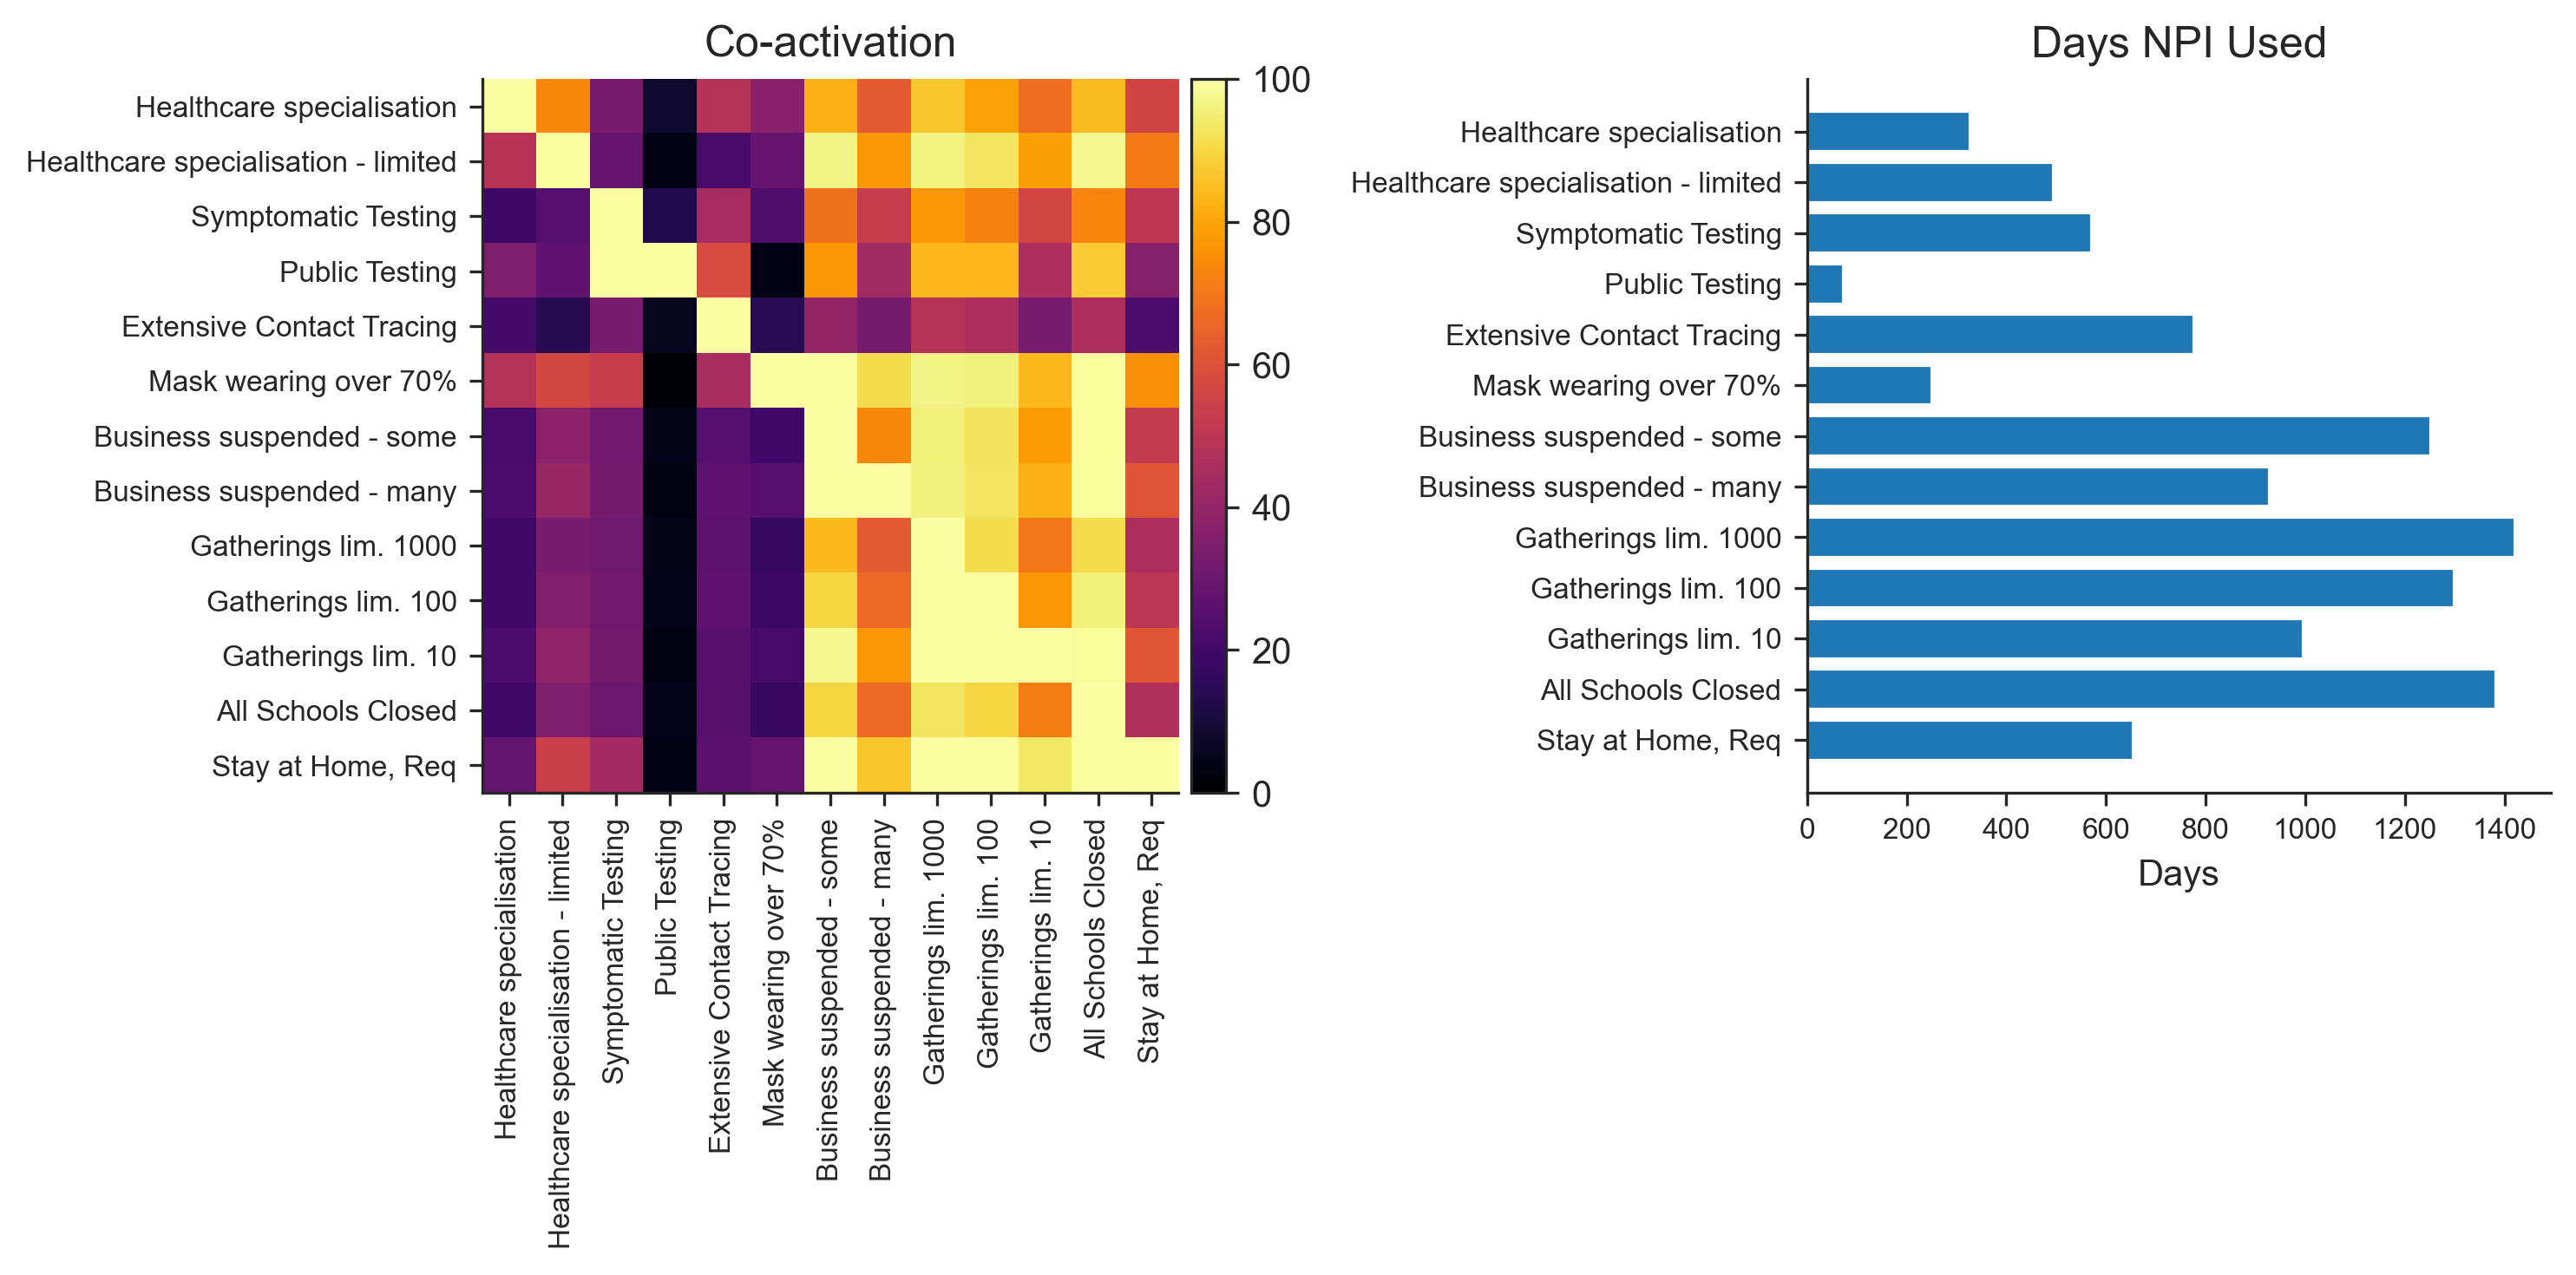

In [258]:
data = dp.preprocess_data("../../data", region_info, oxcgrt_filter, oxcgrt_cm_cols, epifor_features, final_features_ordered,ox_epi, epifor_end_date="2020-04-20")                       

2020-04-20 00:00:00+00:00
Bosnia and Herzegovina, 49.0
Bulgaria, 43.0
Croatia, 47.0
Finland, 98.0
Malaysia, 89.0
Slovenia, 77.0
South Africa, 58.0


/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-pa

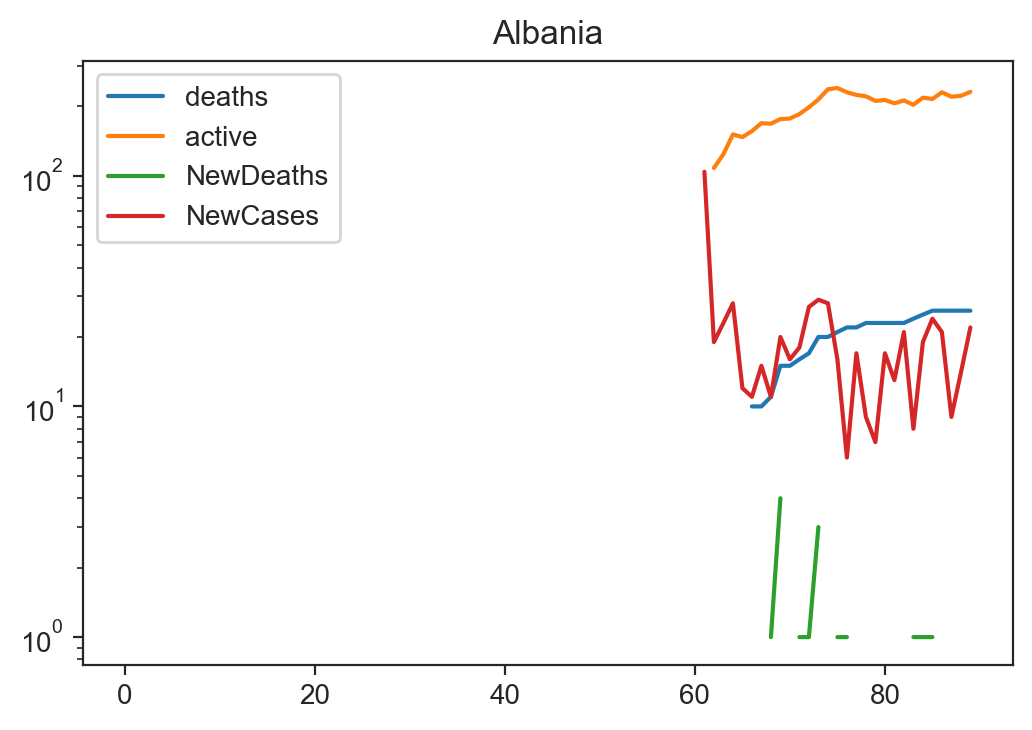

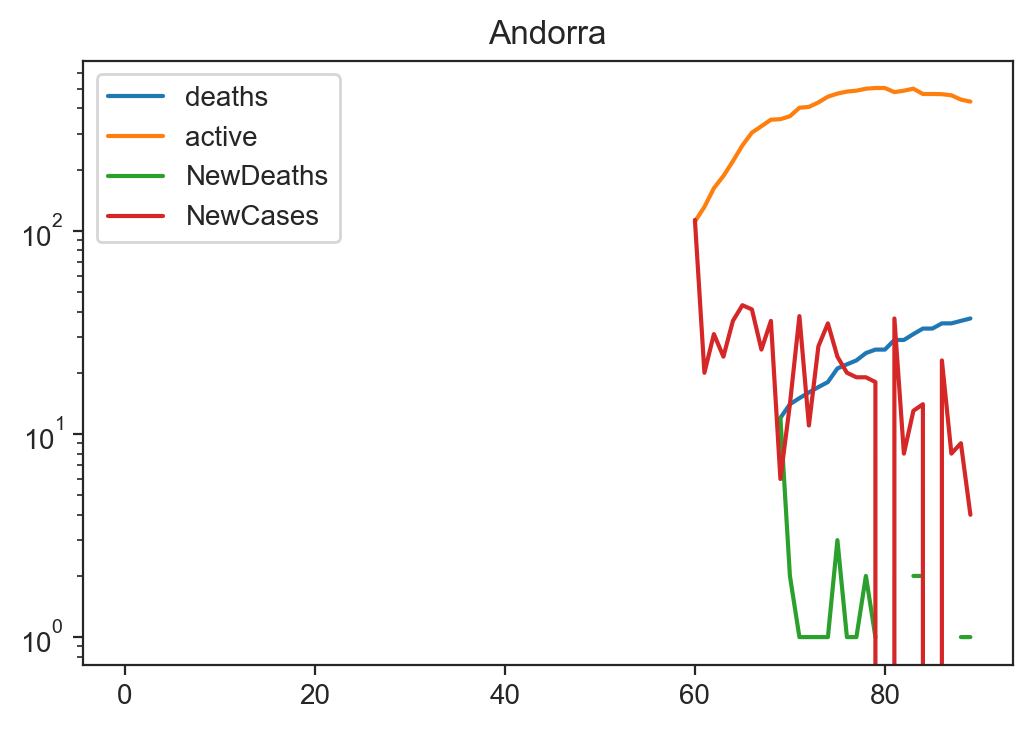

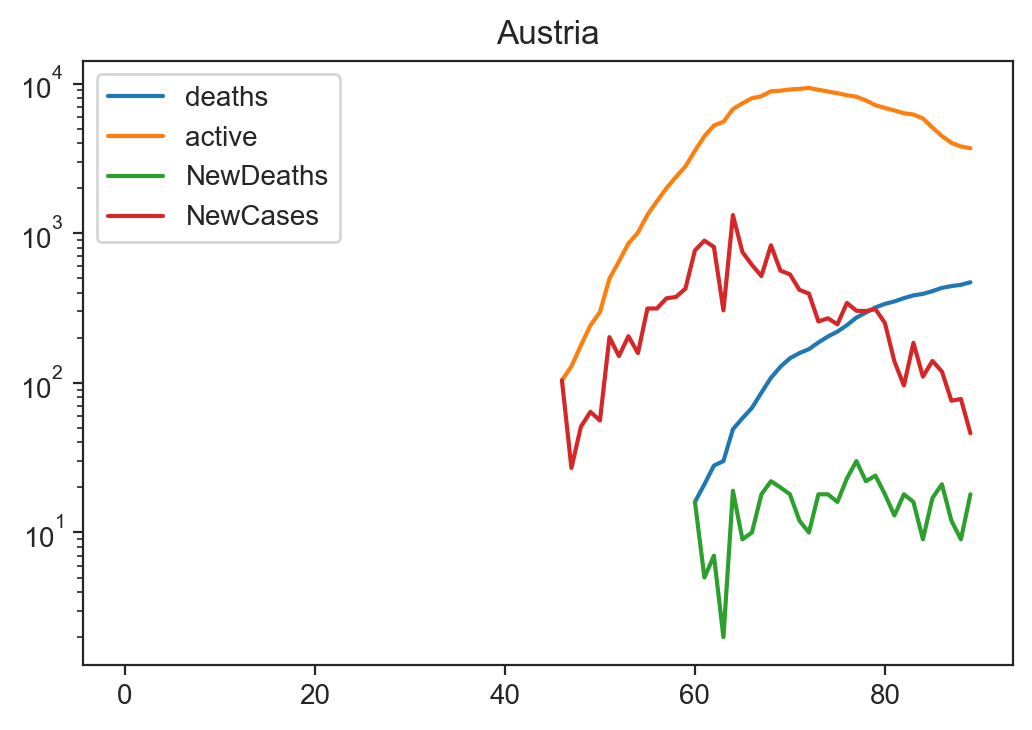

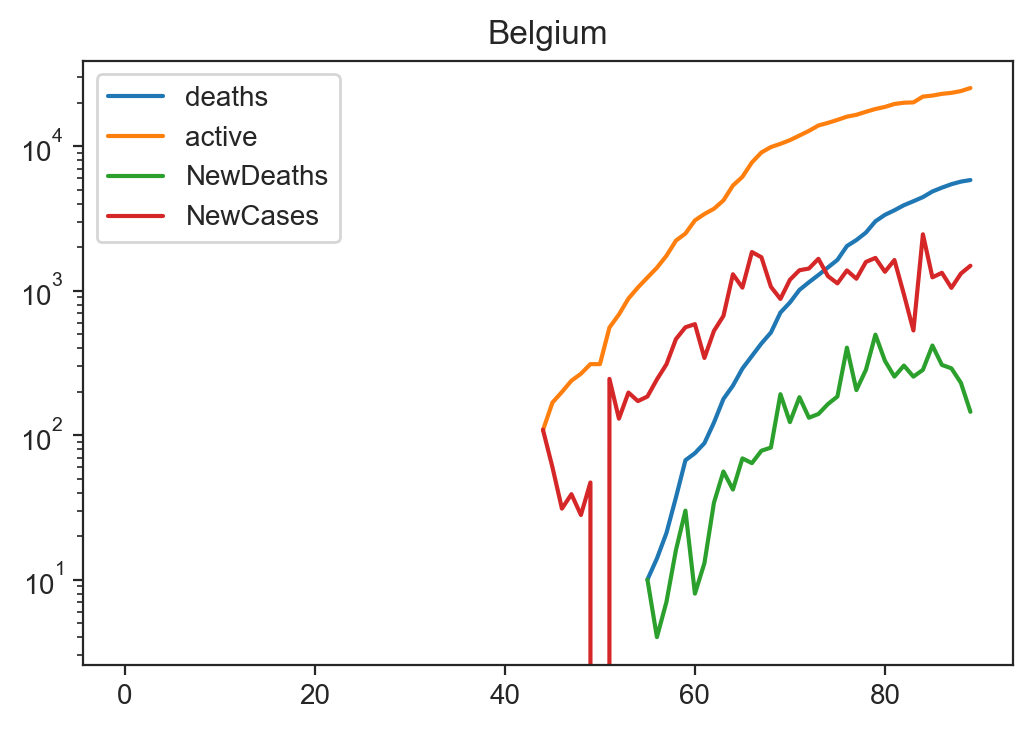

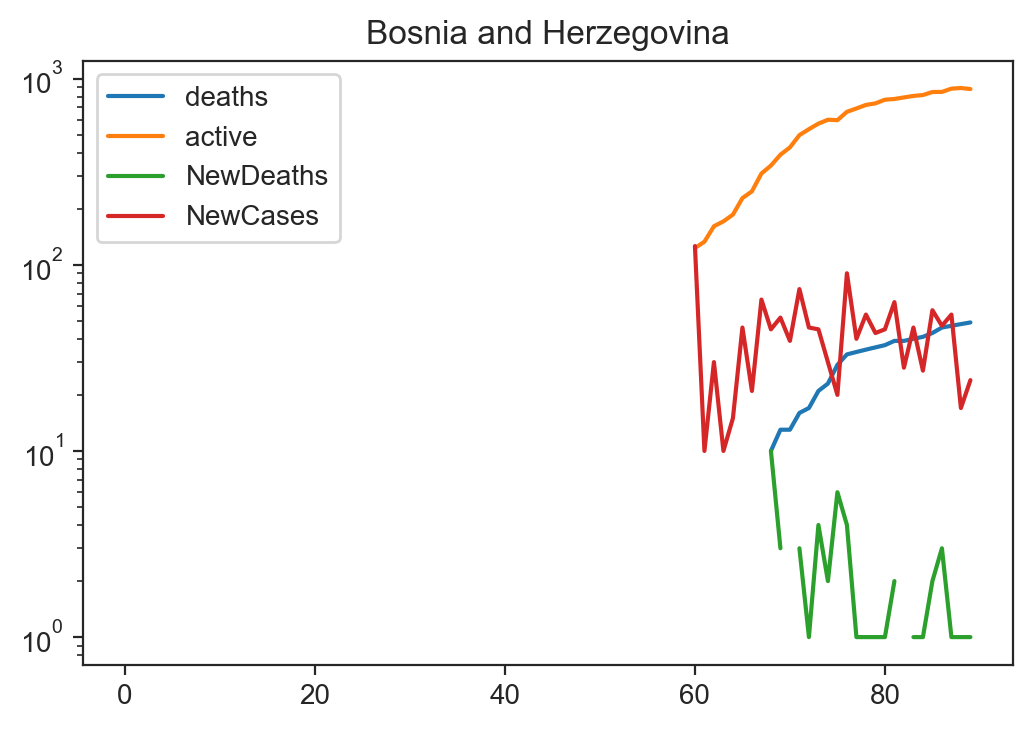

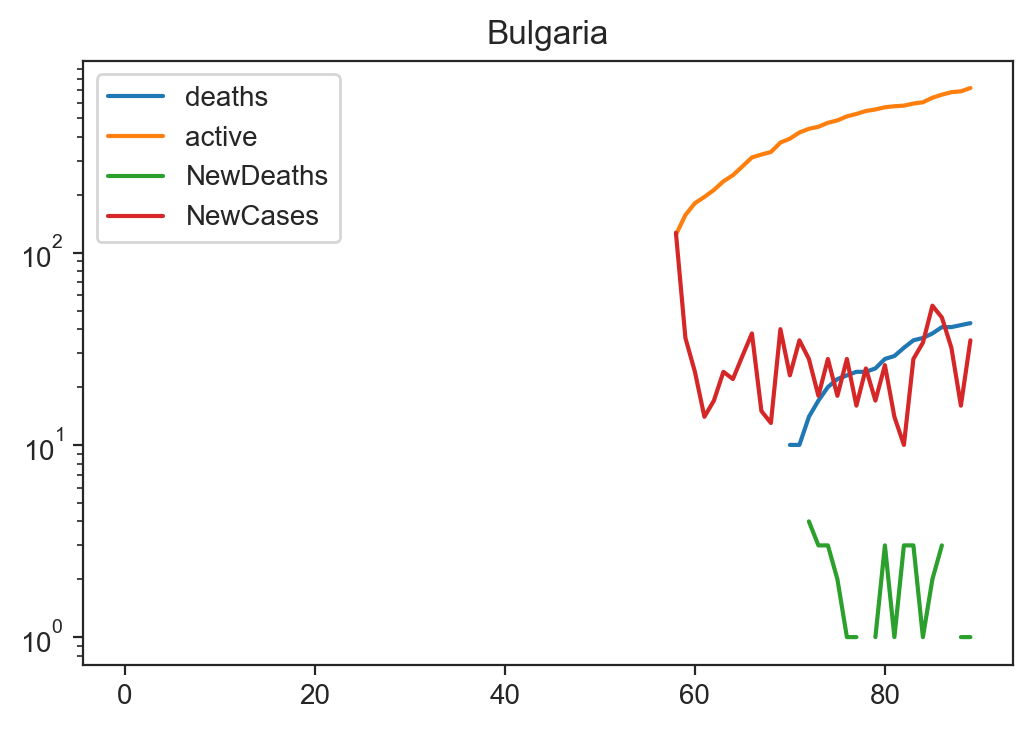

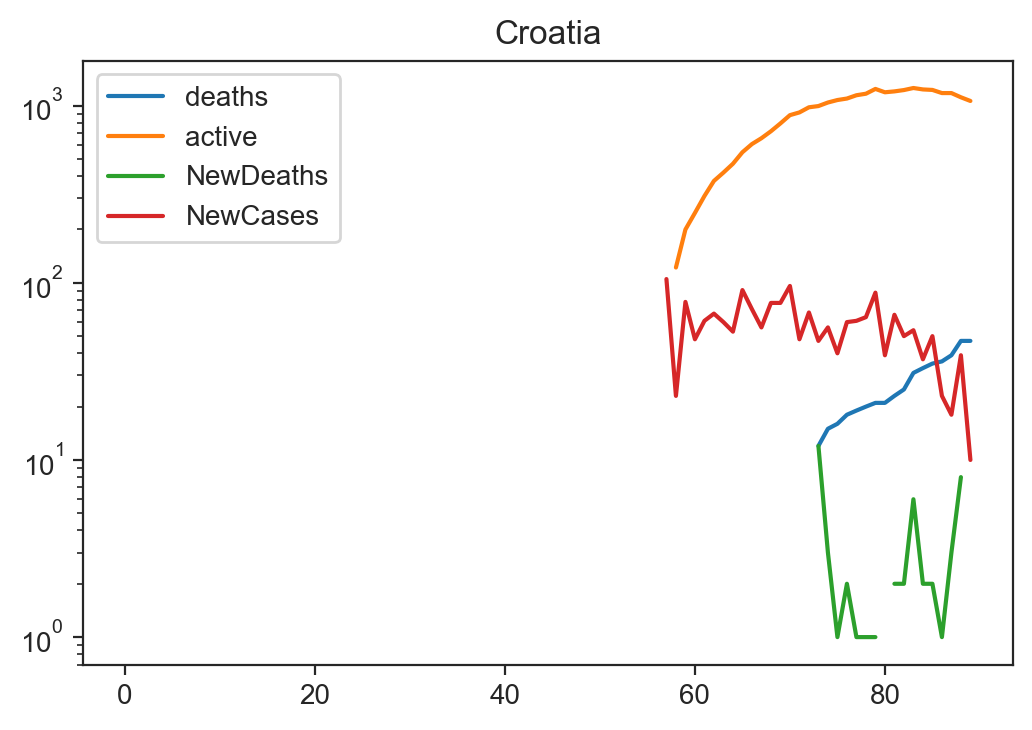

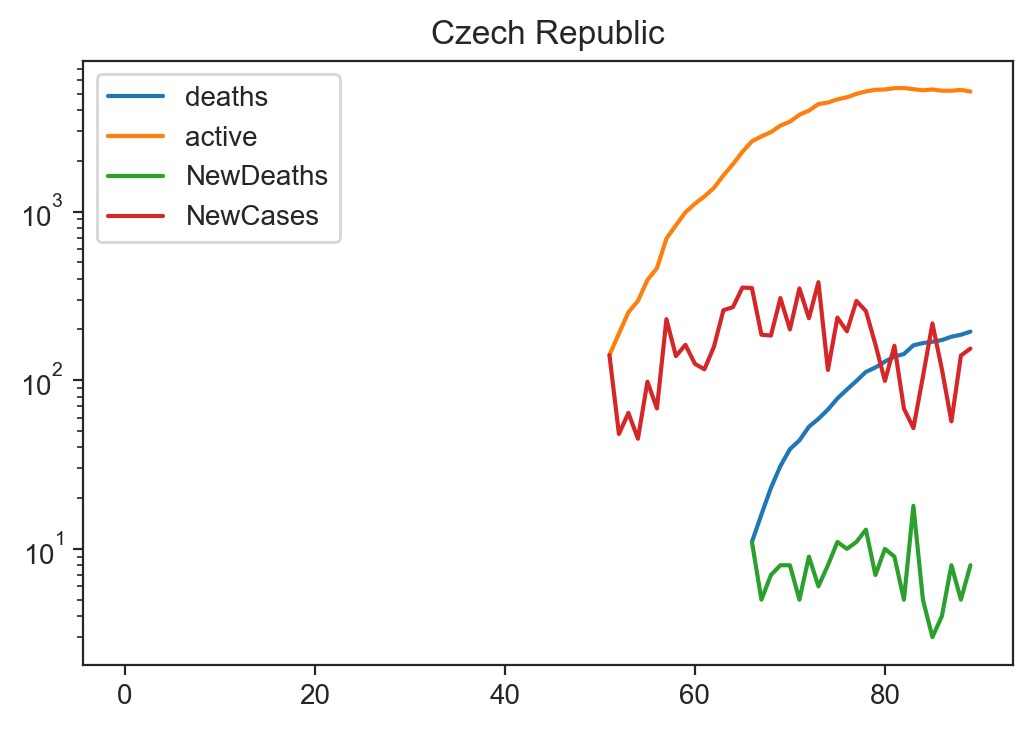

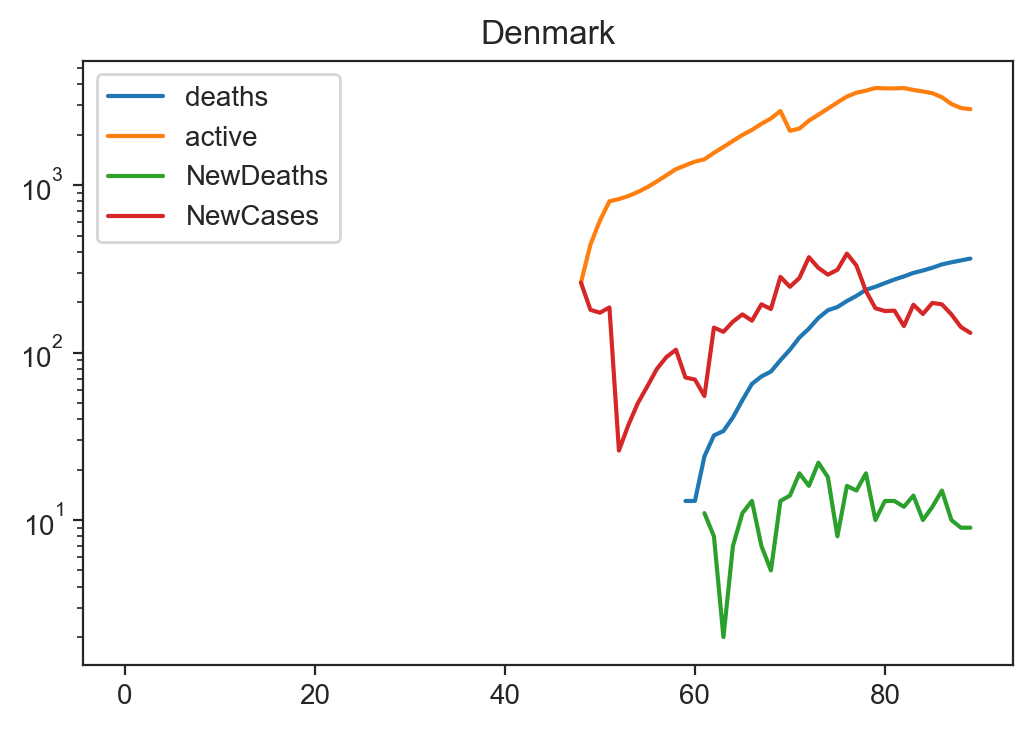

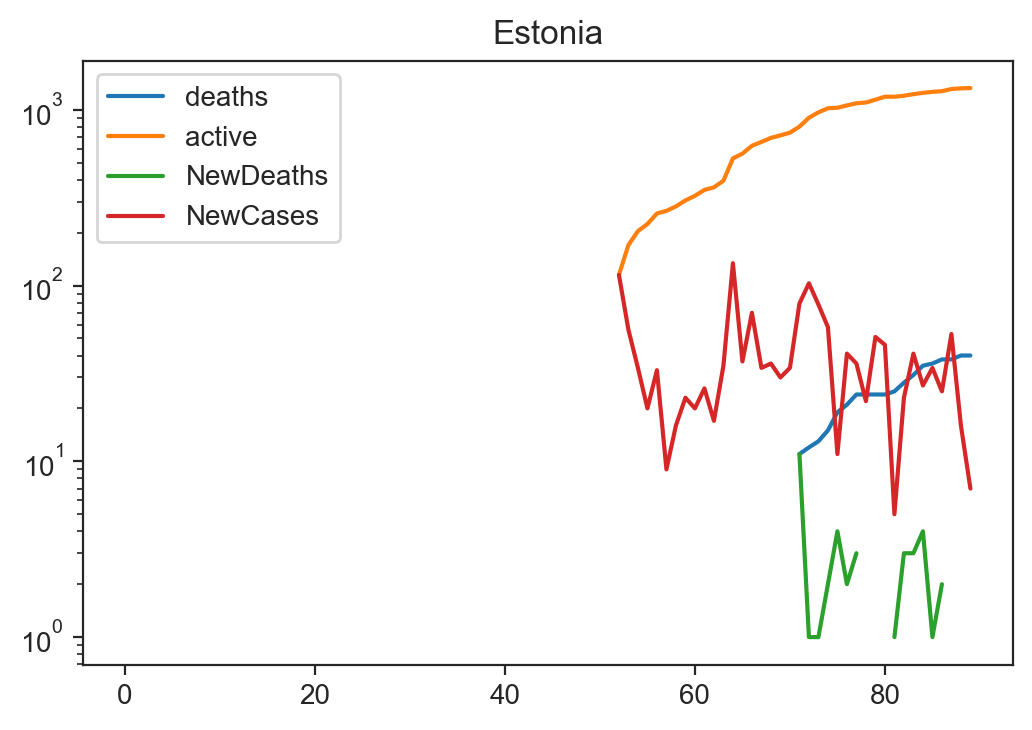

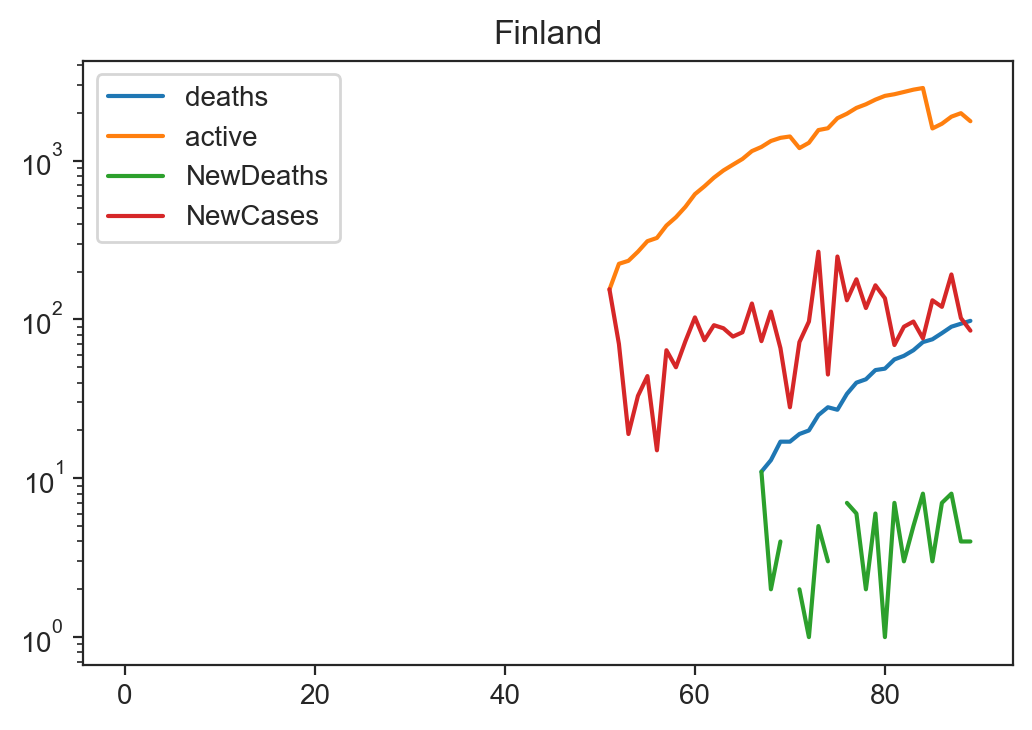

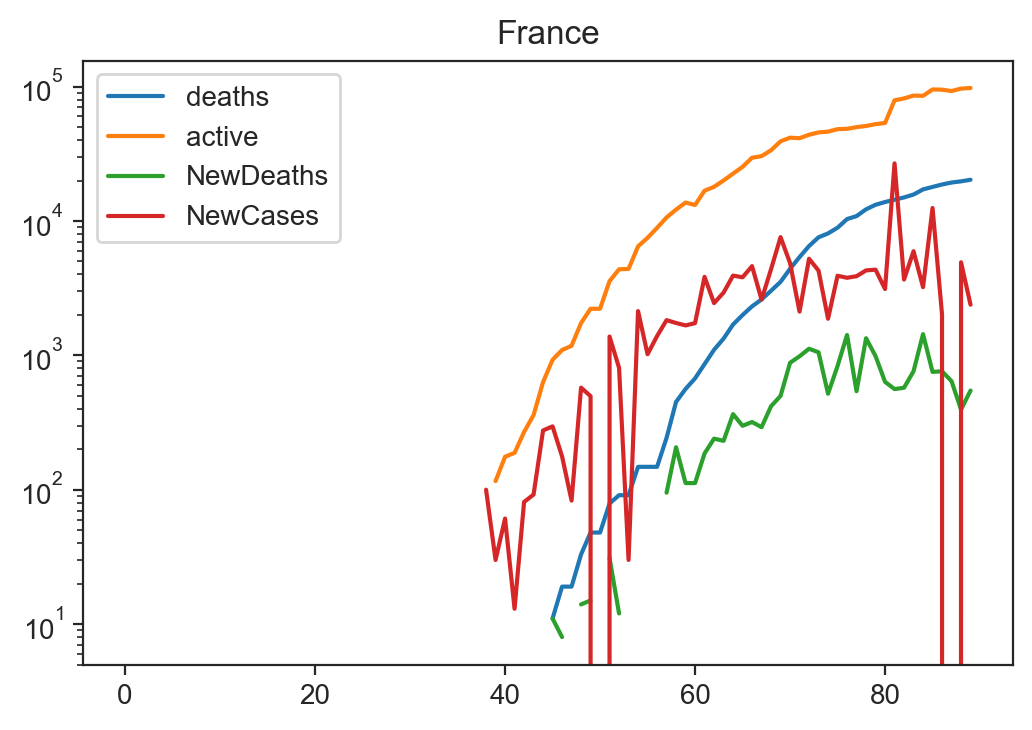

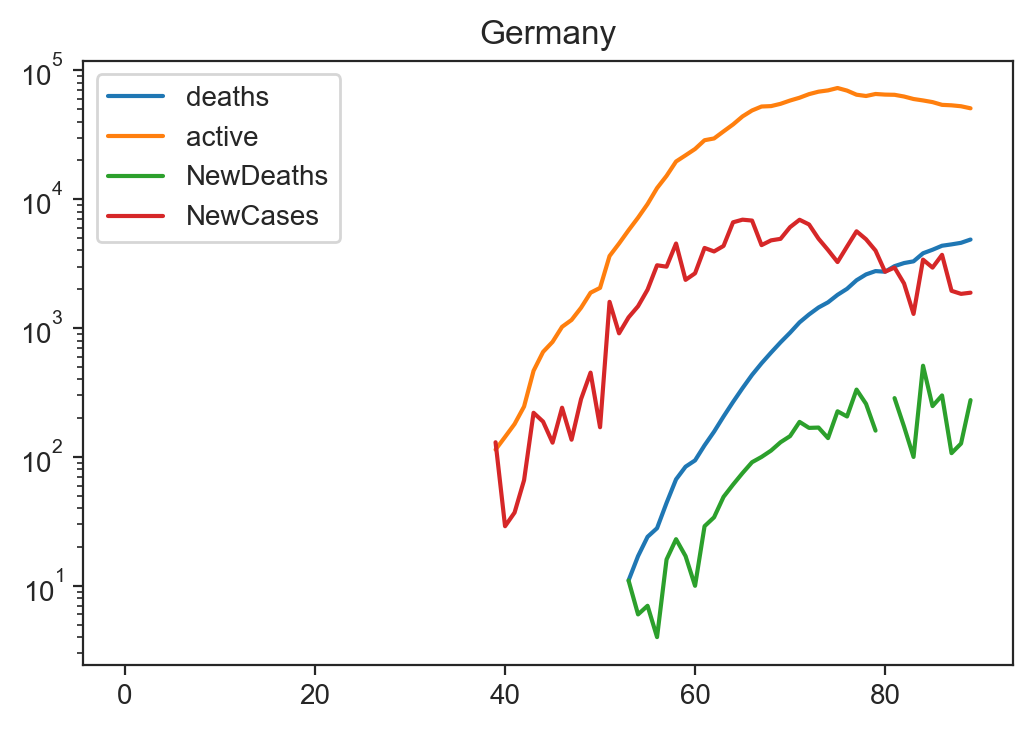

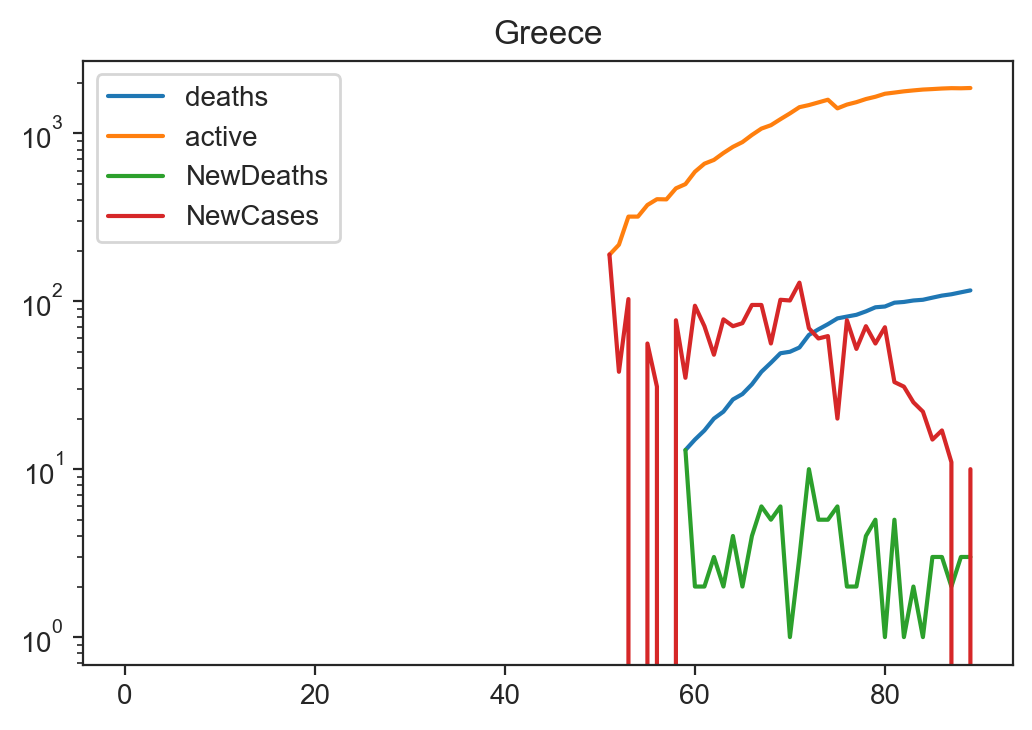

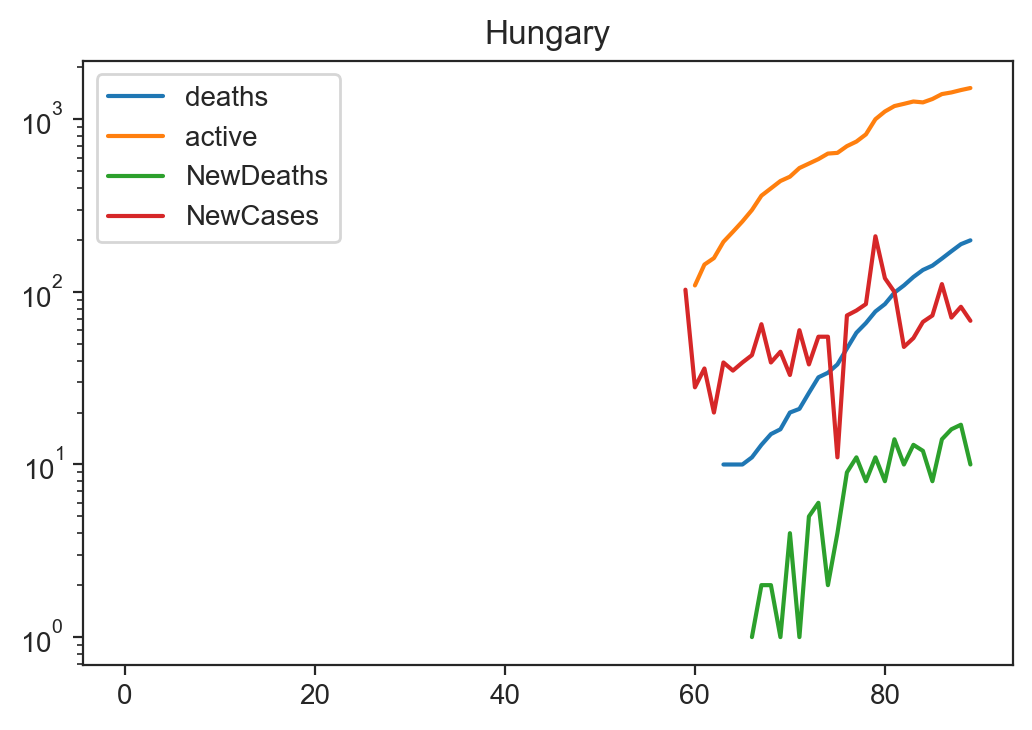

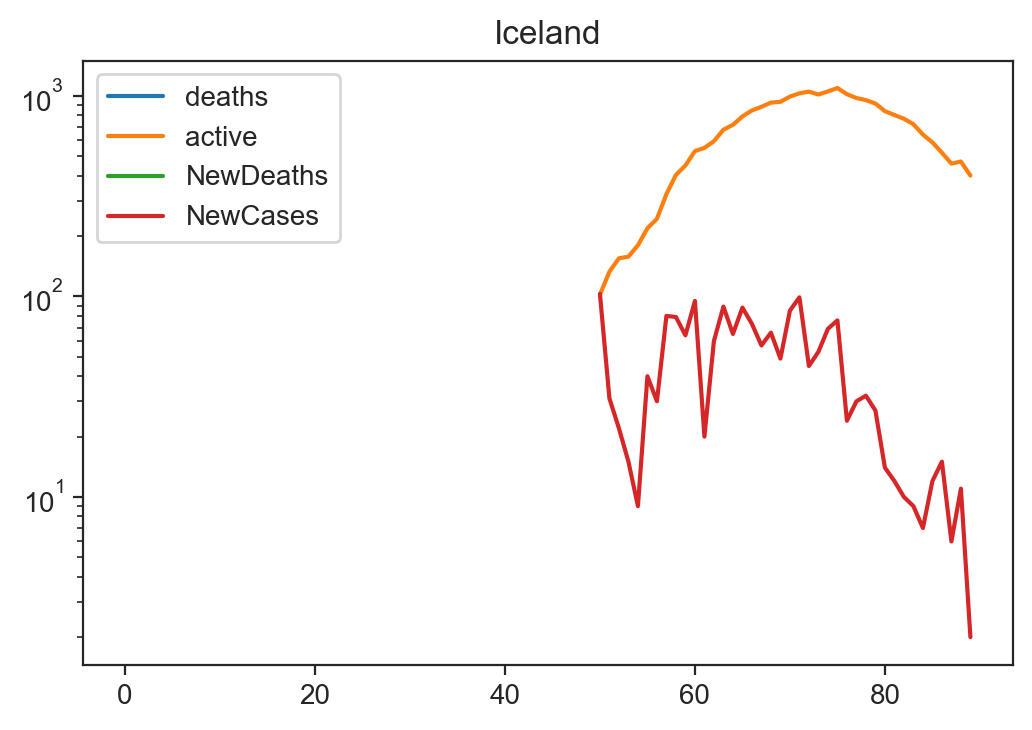

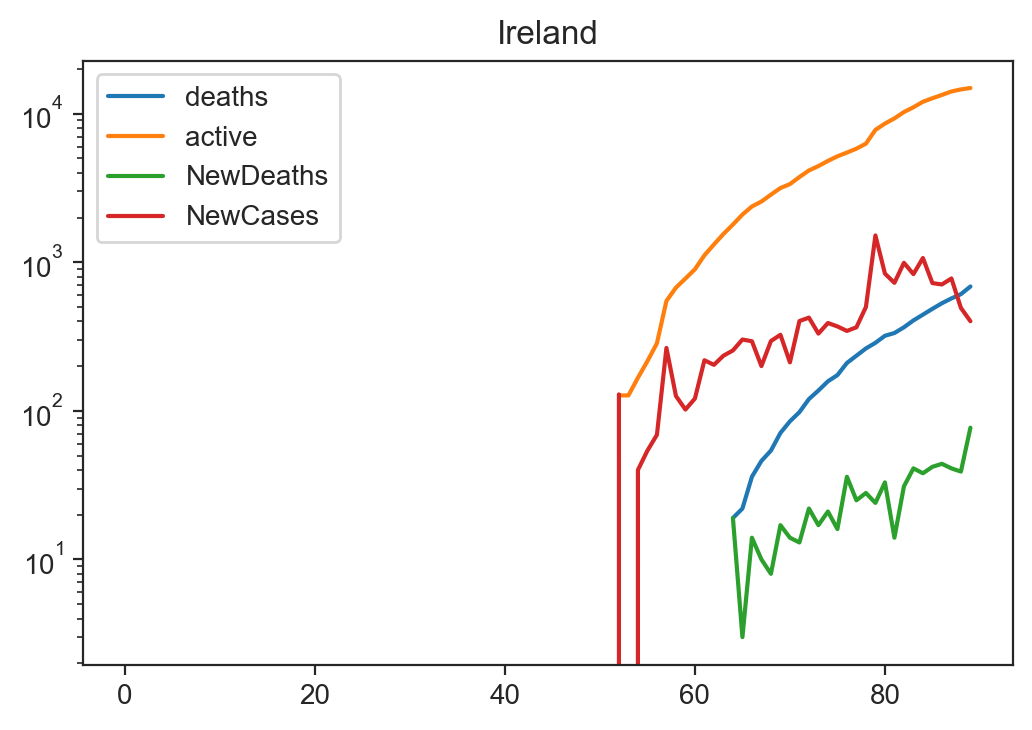

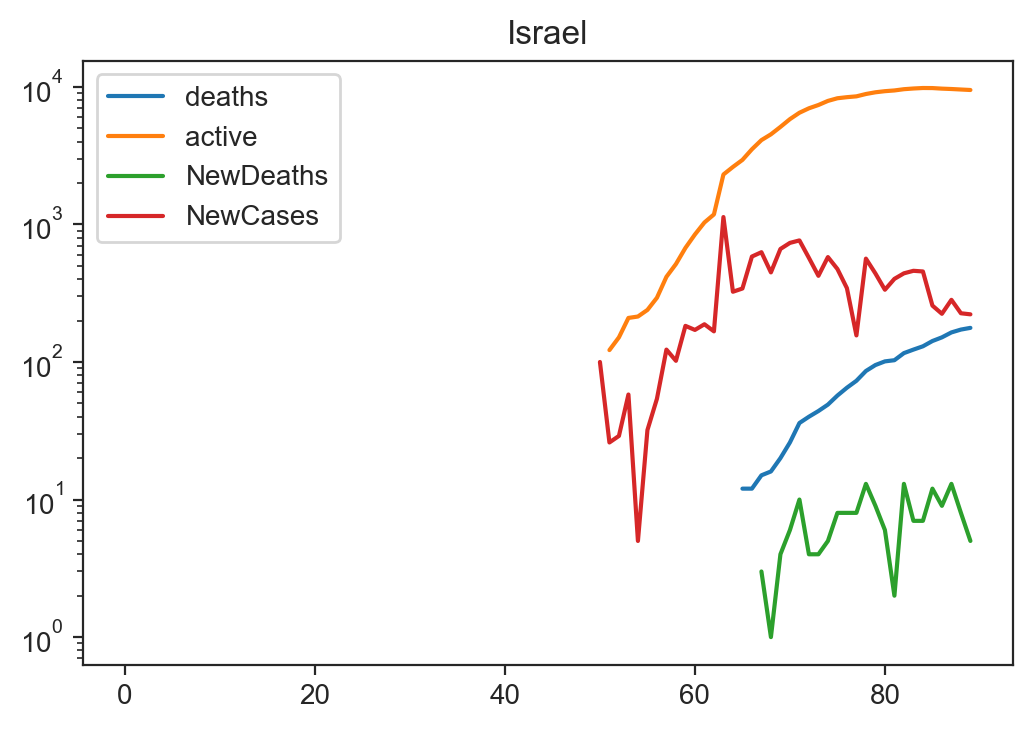

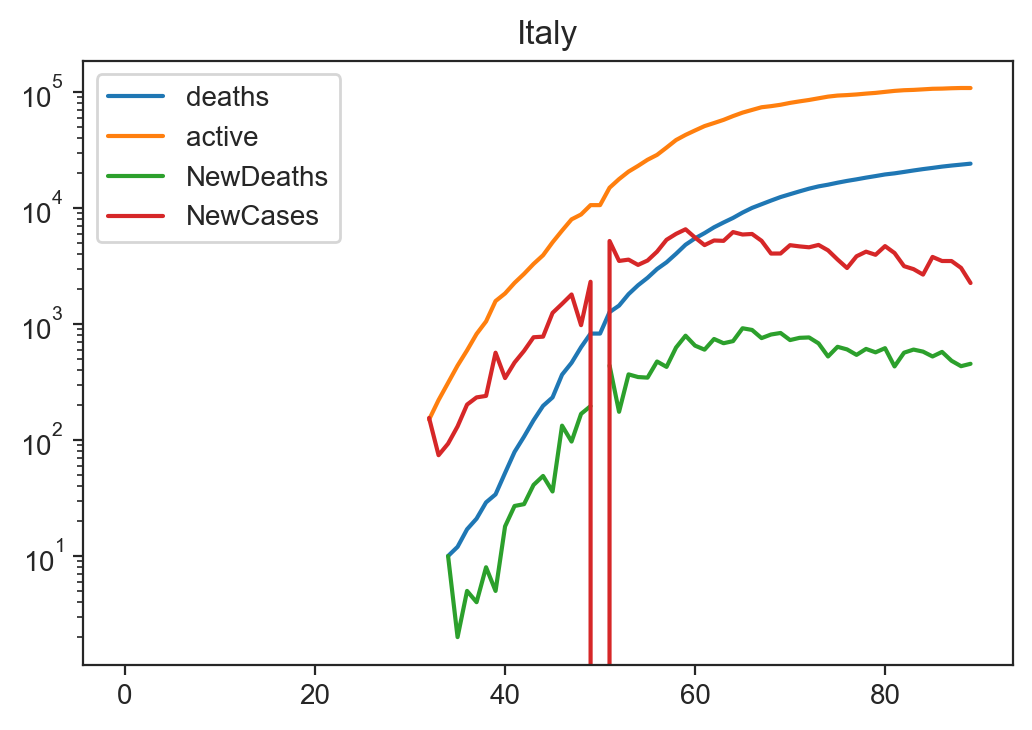

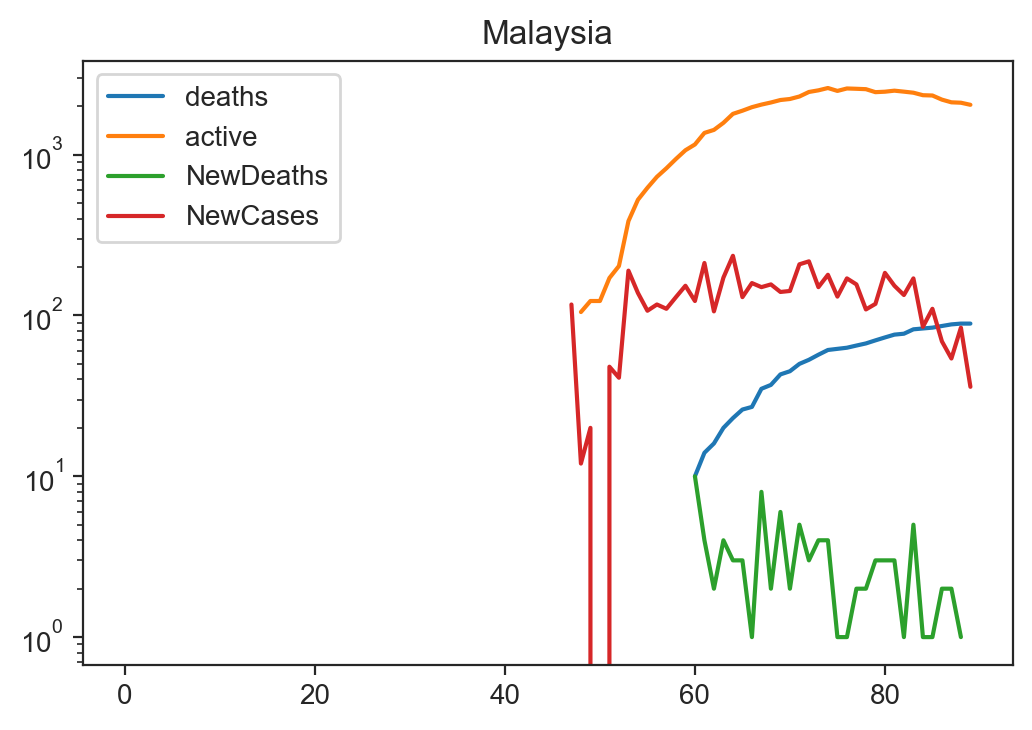

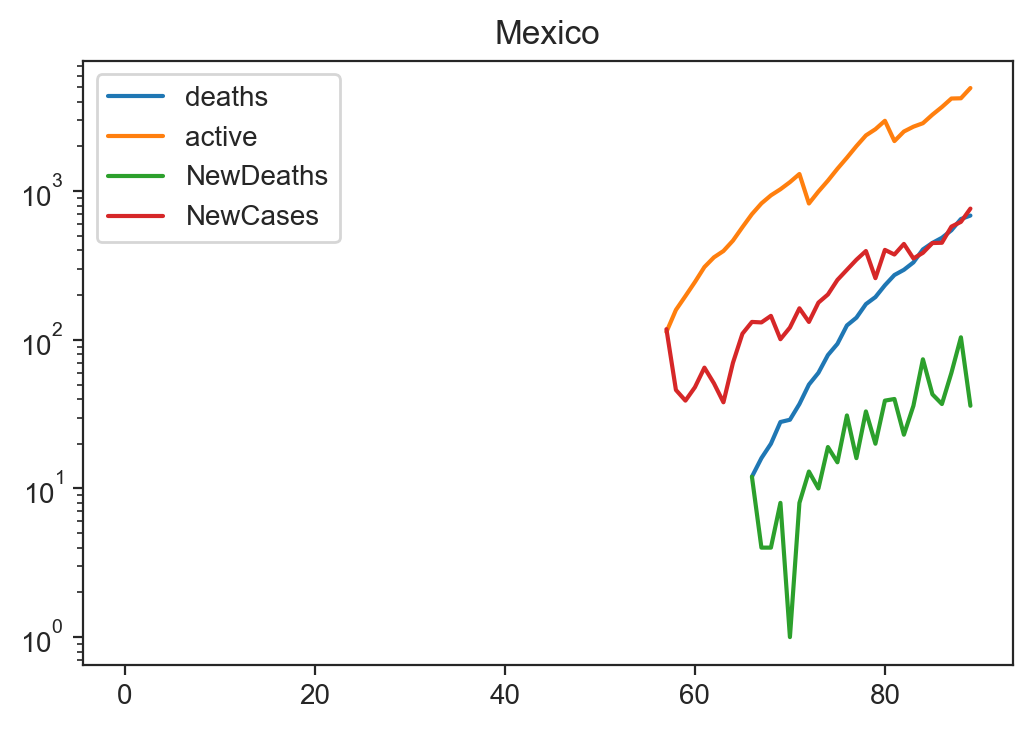

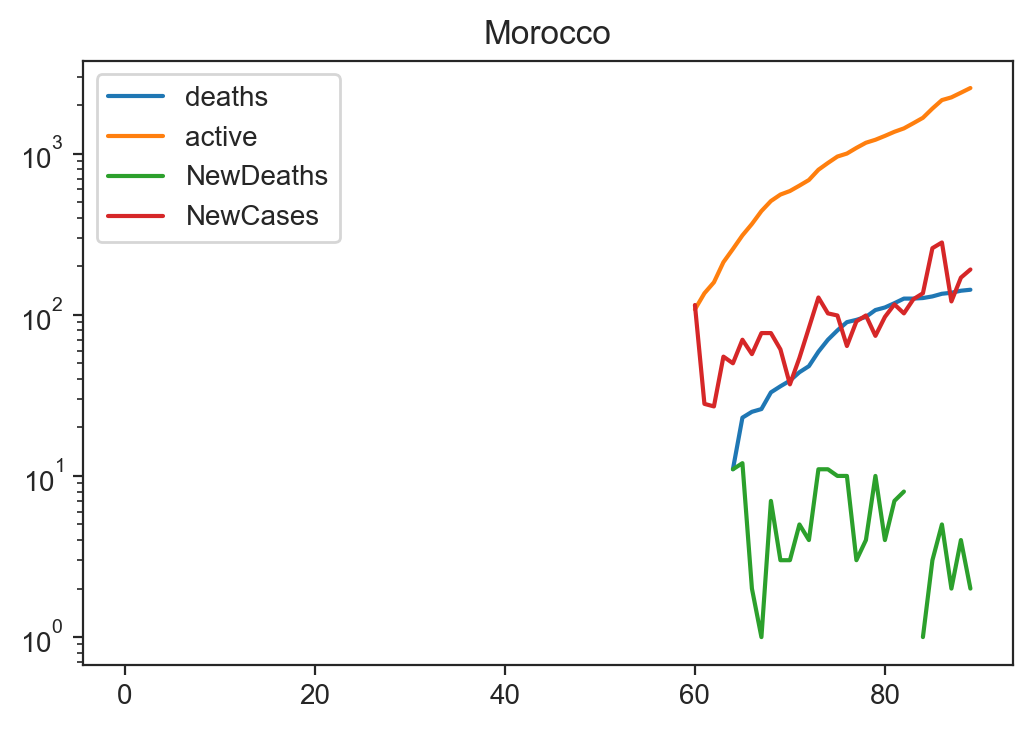

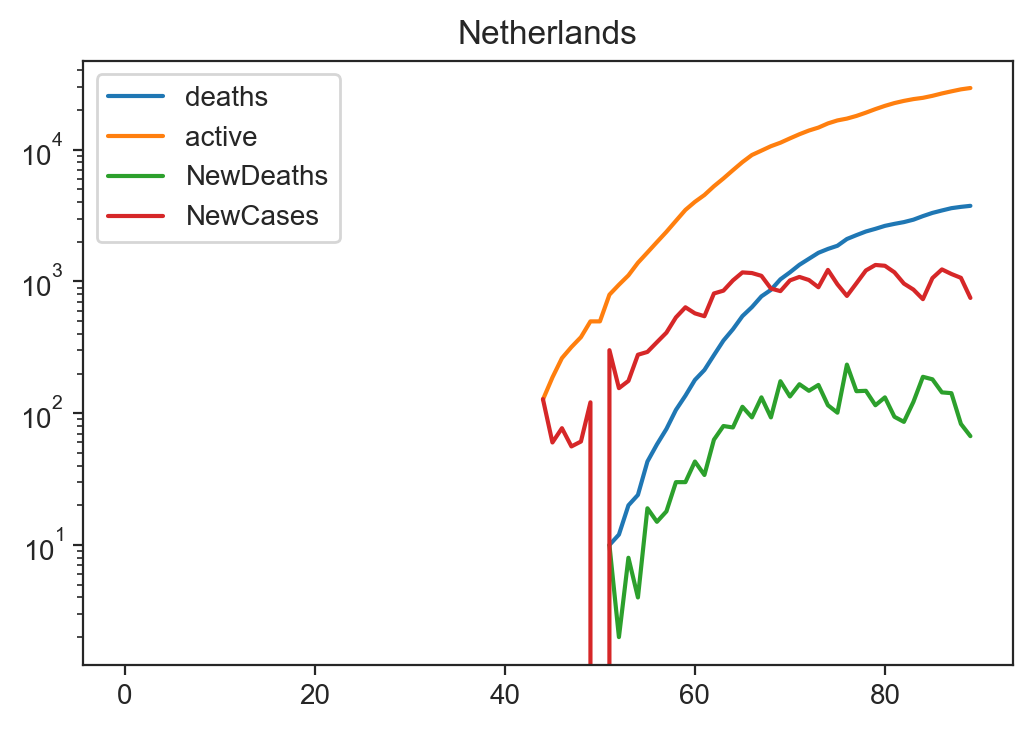

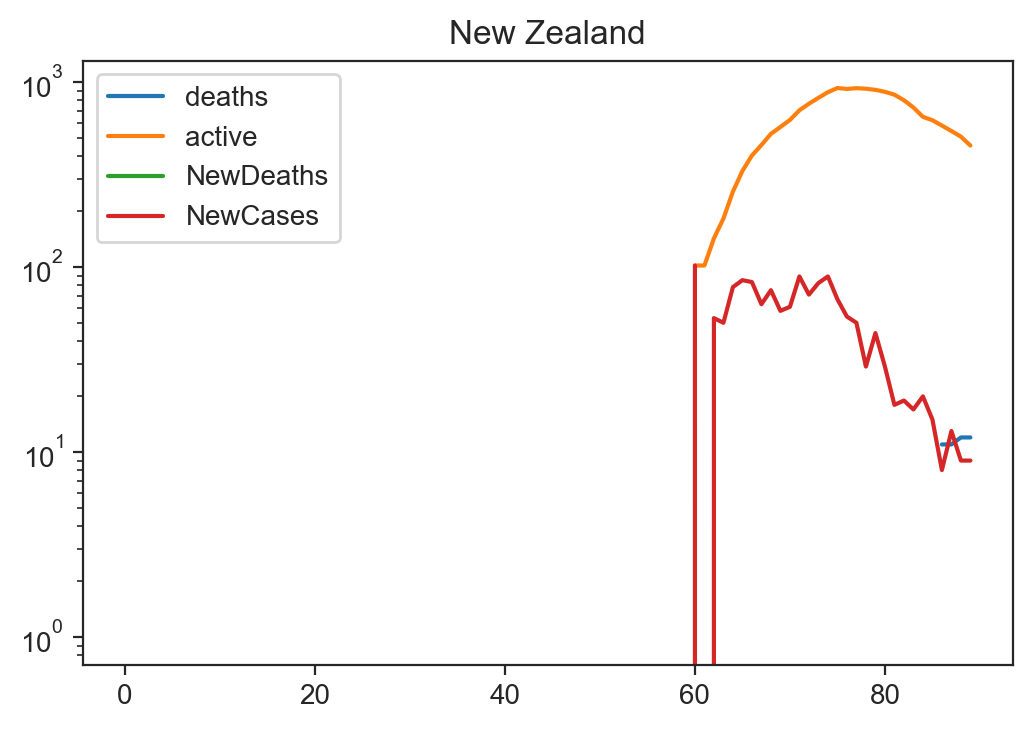

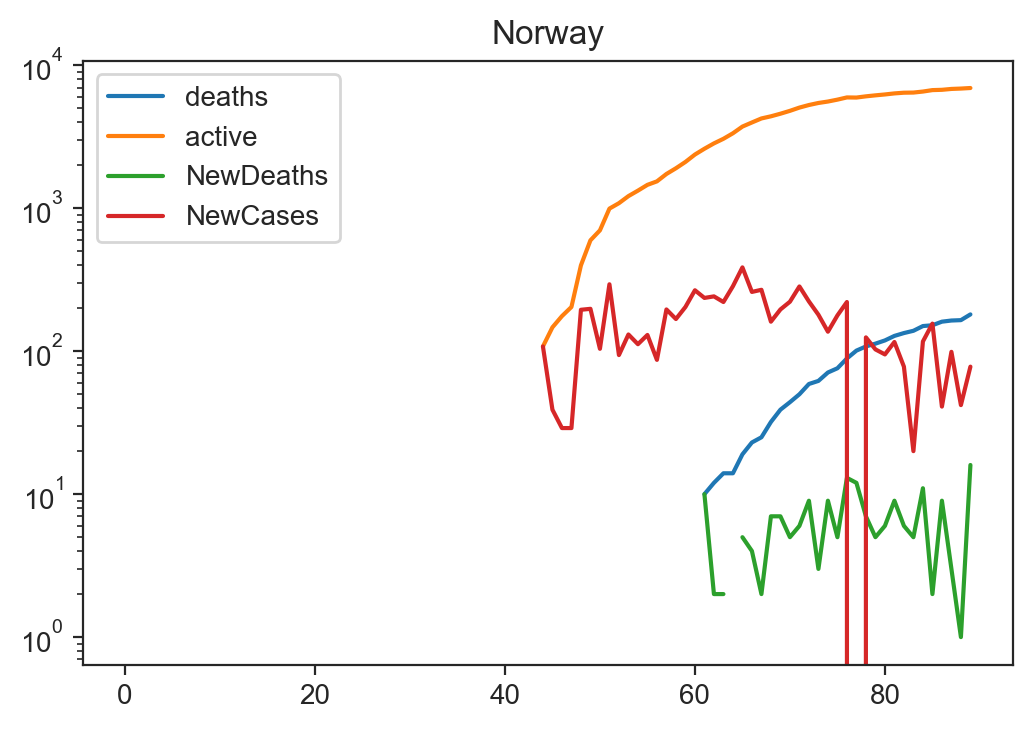

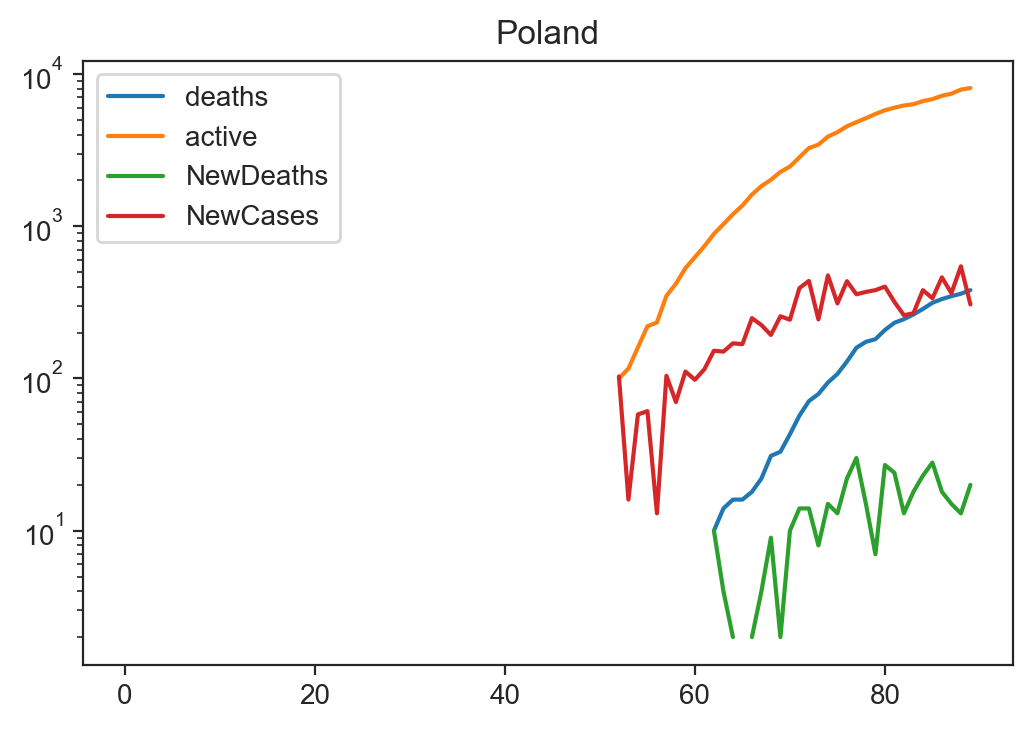

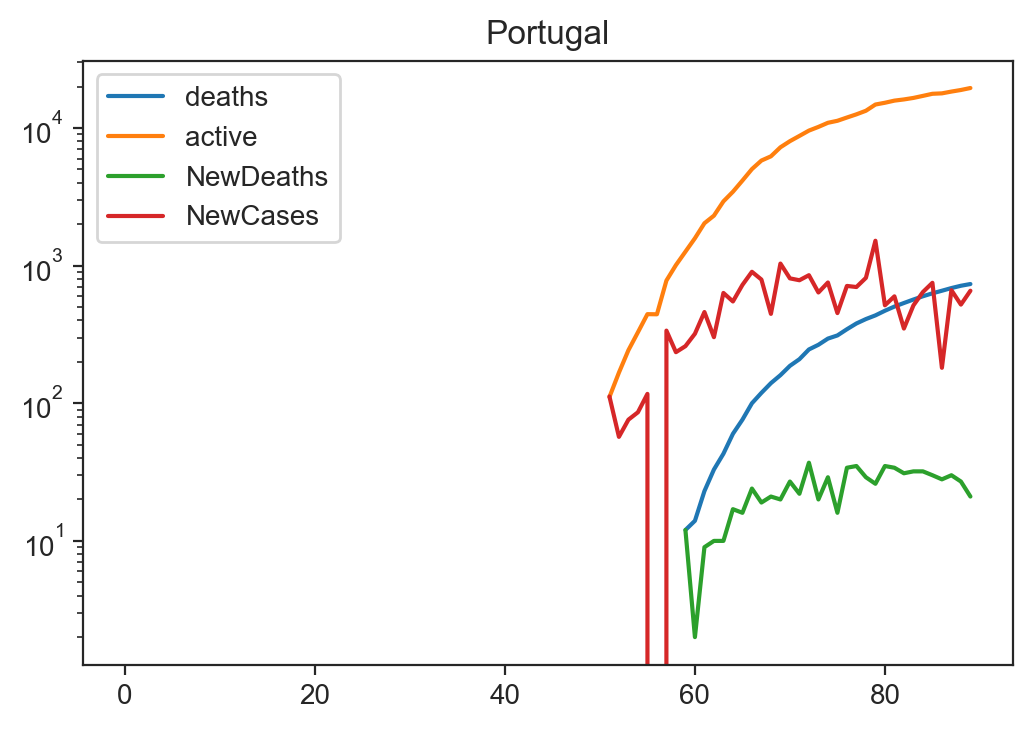

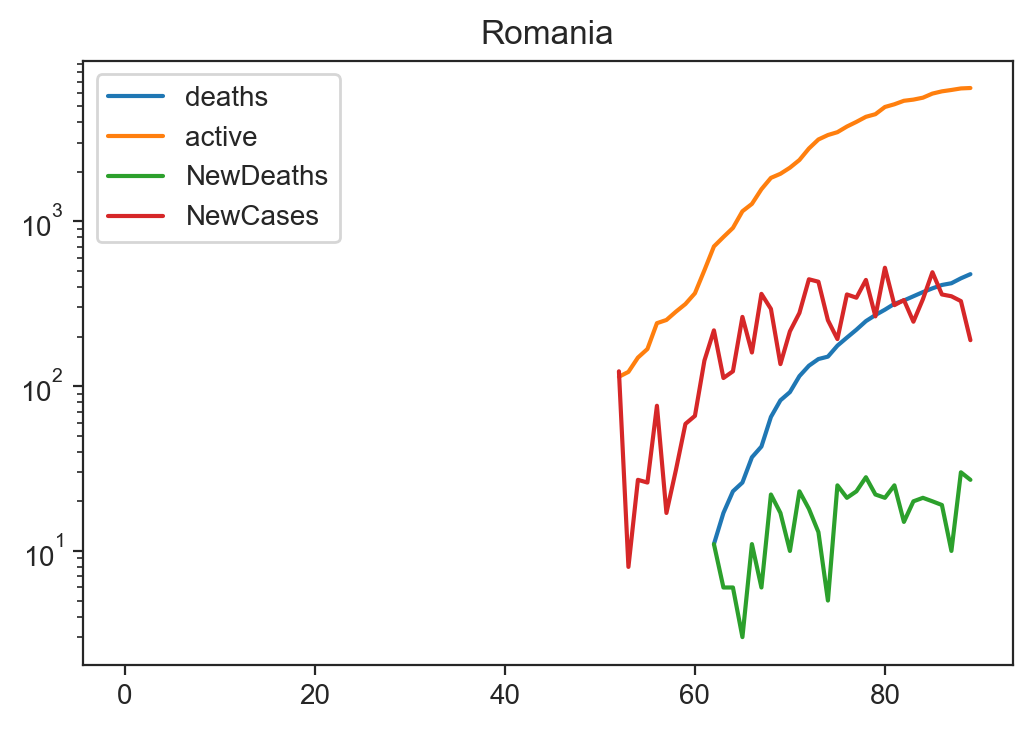

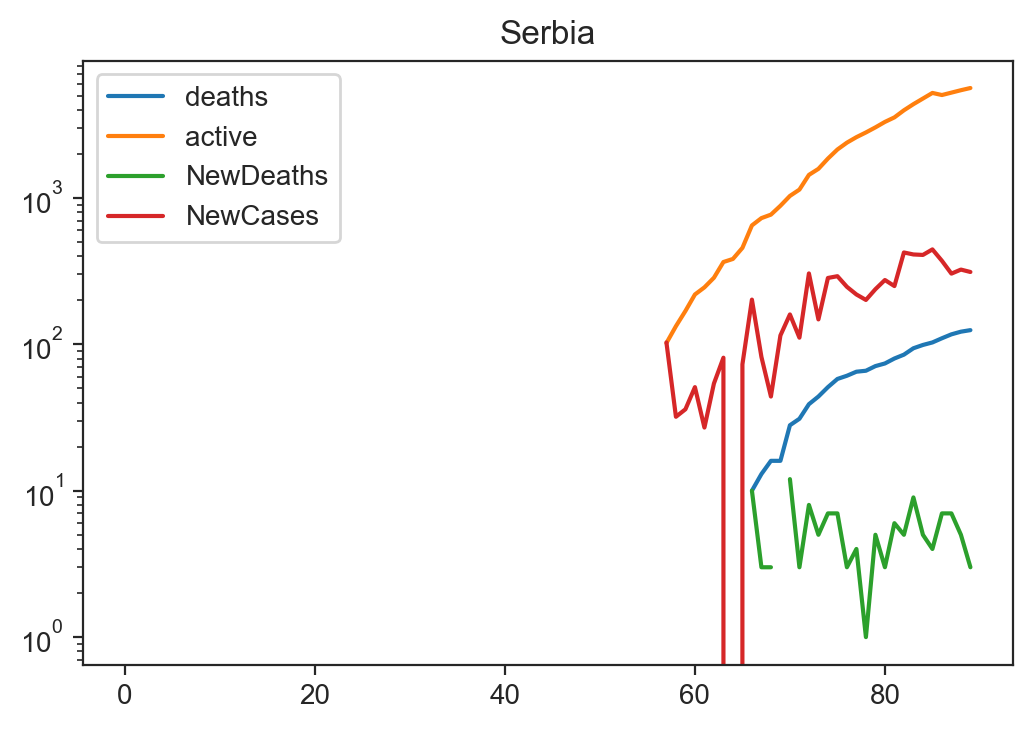

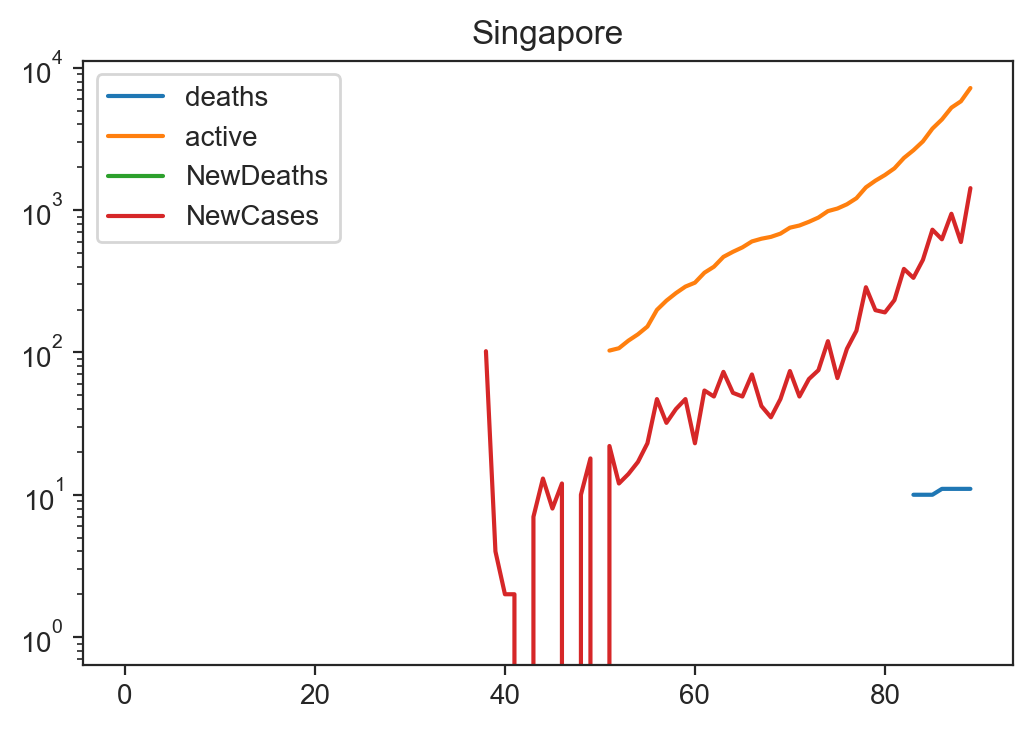

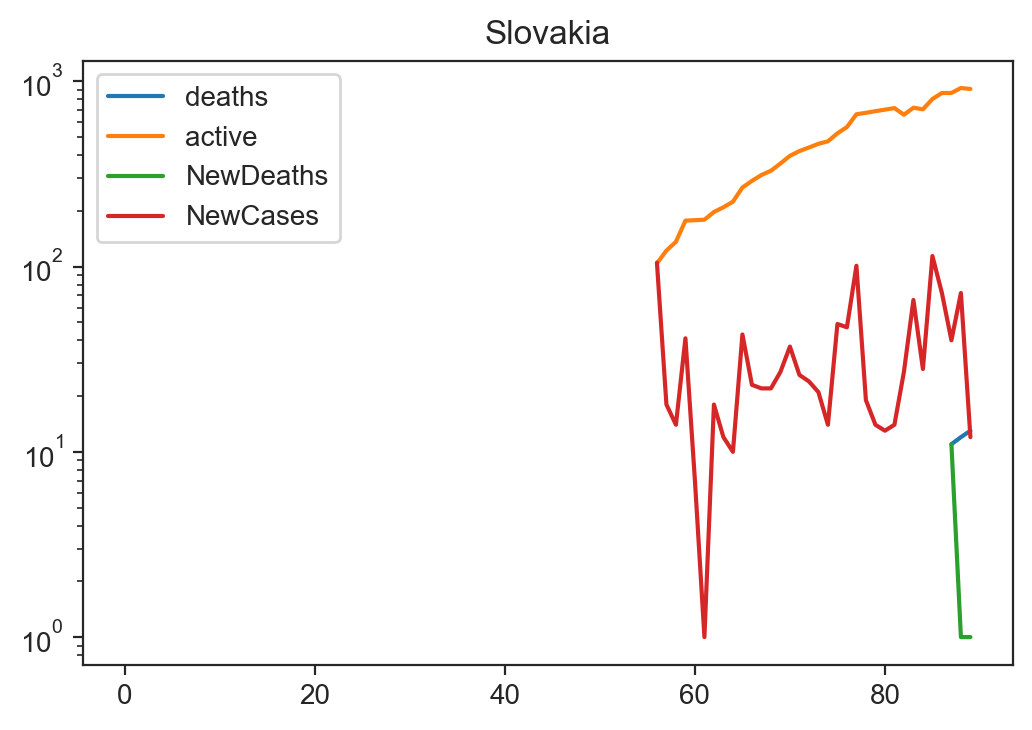

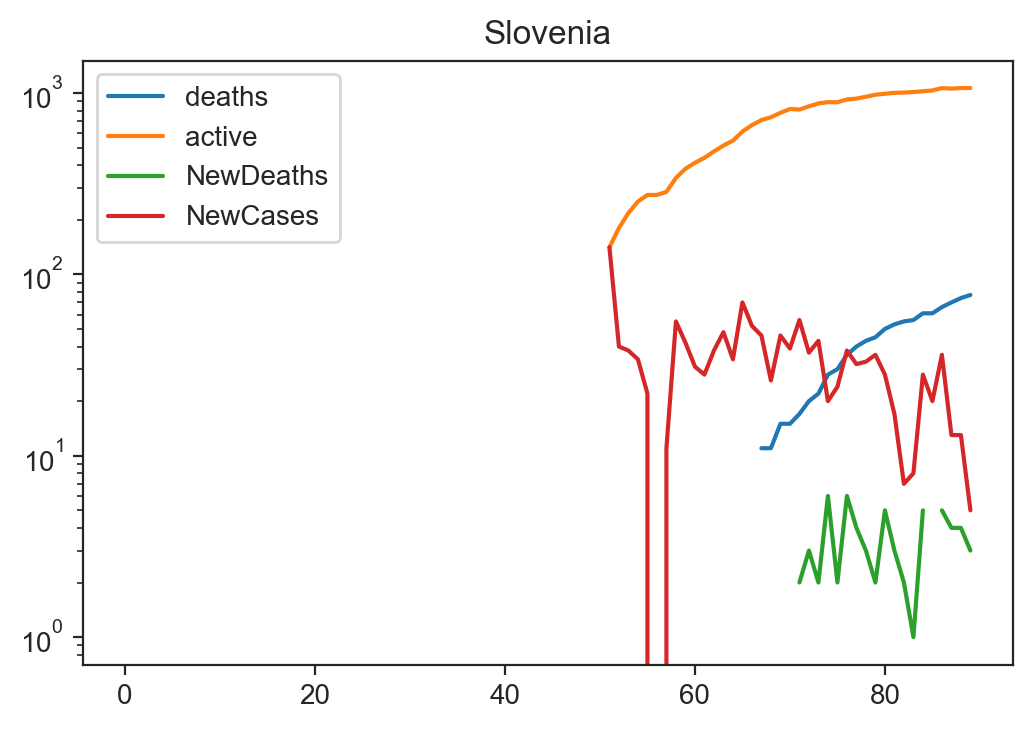

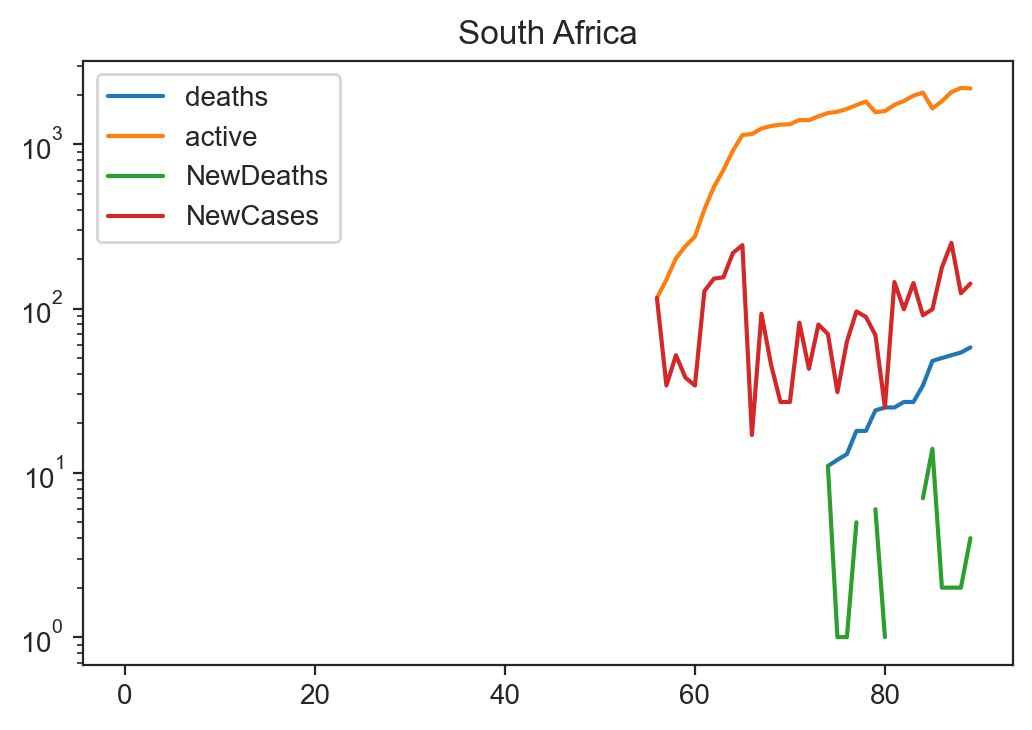

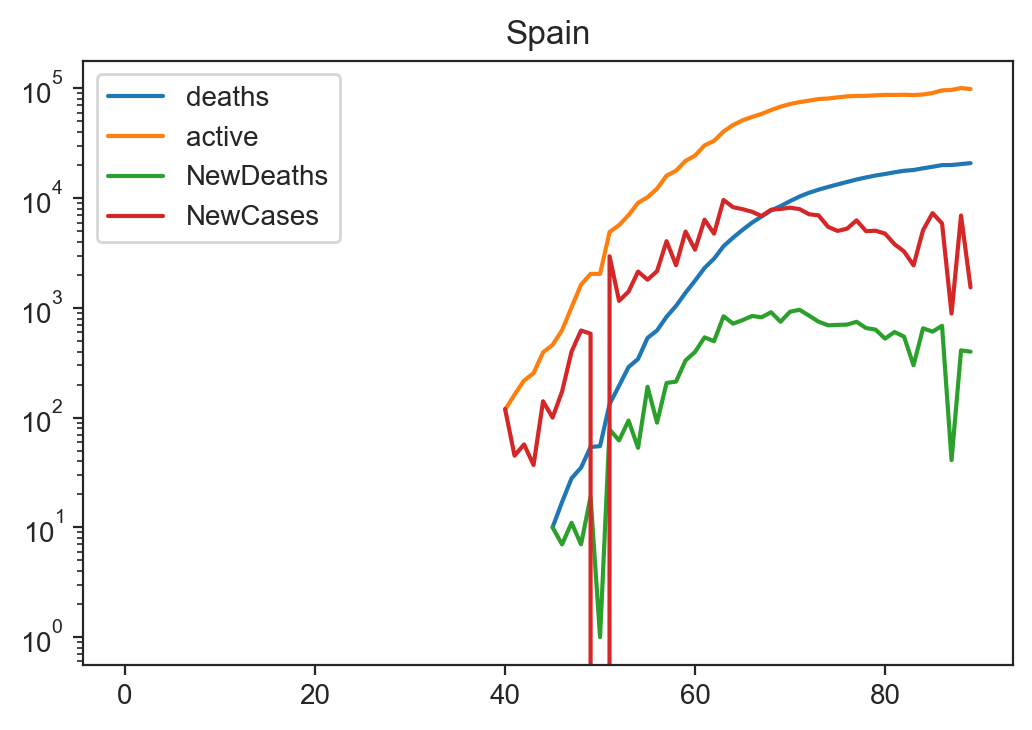

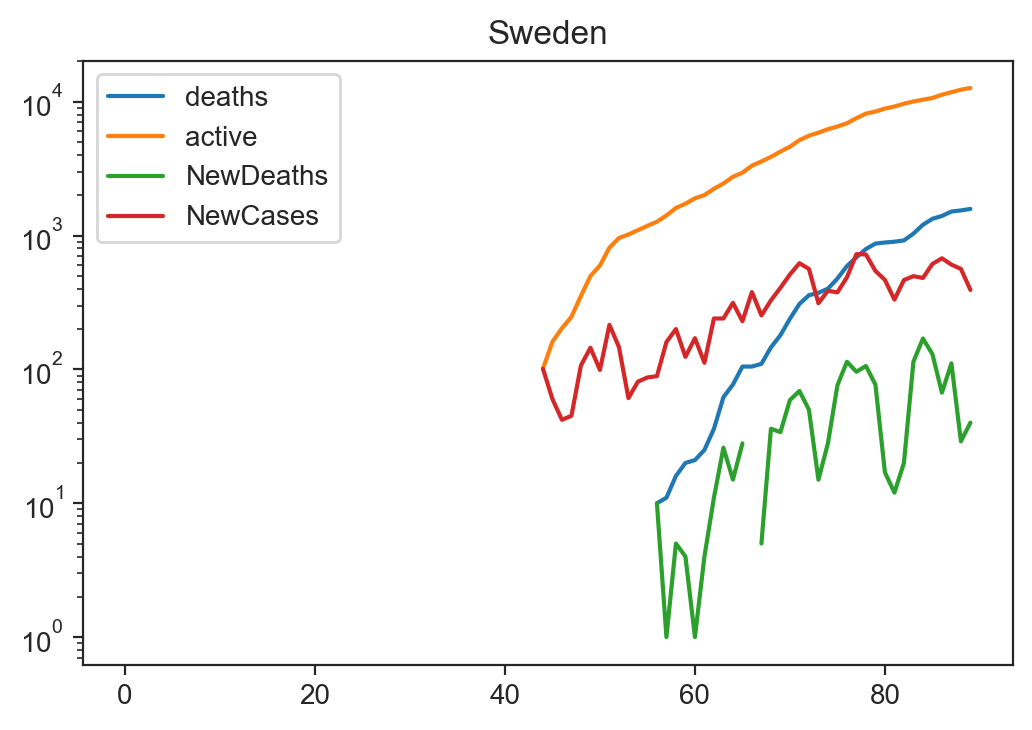

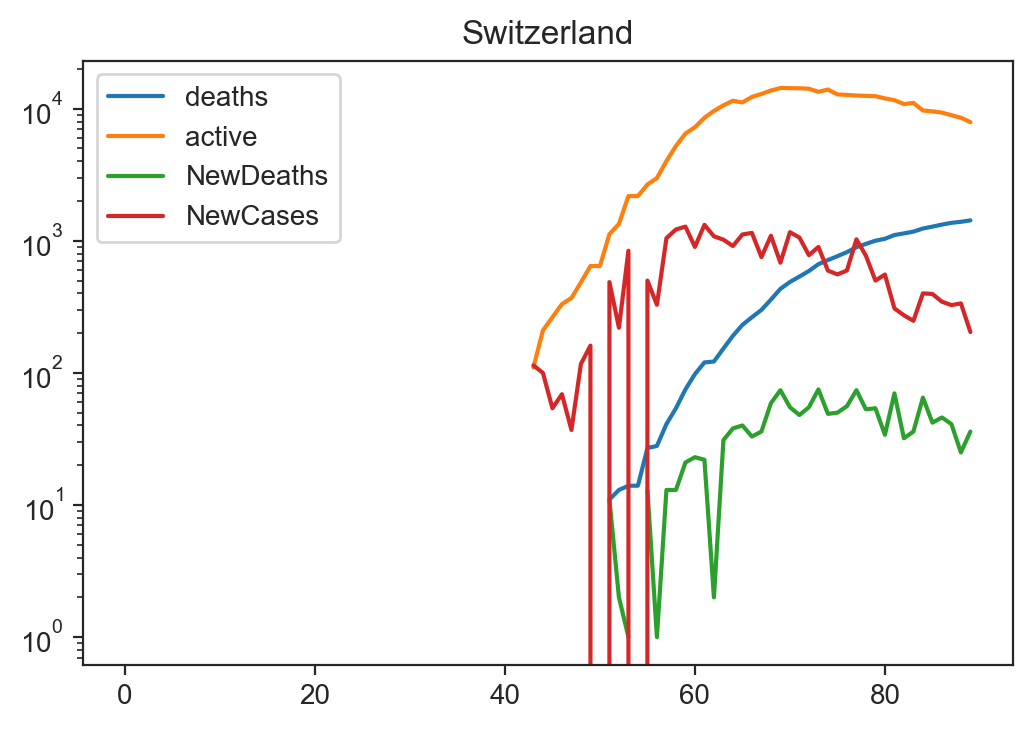

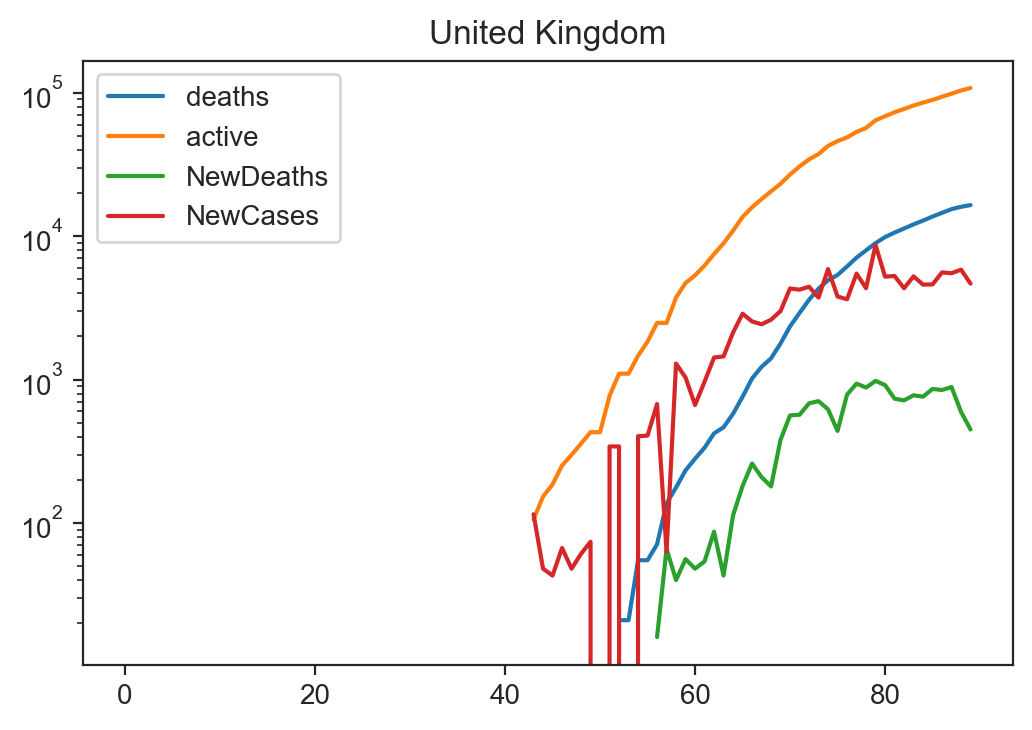

In [260]:
print(data.Ds[-1])
for indx, region in enumerate(region_names):
    if data.Deaths[indx, -1] > 40 and data.Deaths[indx, -1] < 100:
        print(f"{region}, {data.Deaths[indx, -1]}")

for indx, region in enumerate(region_names):
    dts = data.Ds
    locs = np.arange(0, nDs, 7)
    xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]
    plt.figure(dpi=200)
    plt.plot(np.arange(len(dts)), data.Deaths[indx, :], label="deaths")
    plt.plot(np.arange(len(dts)), data.Active[indx, :], label="active")
    plt.plot(np.arange(len(dts)), data.NewDeaths[indx, :], label="NewDeaths")
    NewCases = np.zeros(len(dts))
    NewCases[1:] = data.Confirmed[indx, 1:] - data.Confirmed[indx, :-1]
    plt.plot(np.arange(len(dts)), NewCases, label="NewCases")
    plt.legend()
    plt.yscale("log")
    plt.title(region)

In [246]:
region_names

['Albania',
 'Andorra',
 'Austria',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Malaysia',
 'Mexico',
 'Morocco',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom']

In [72]:
ActiveCMs = data.ActiveCMs

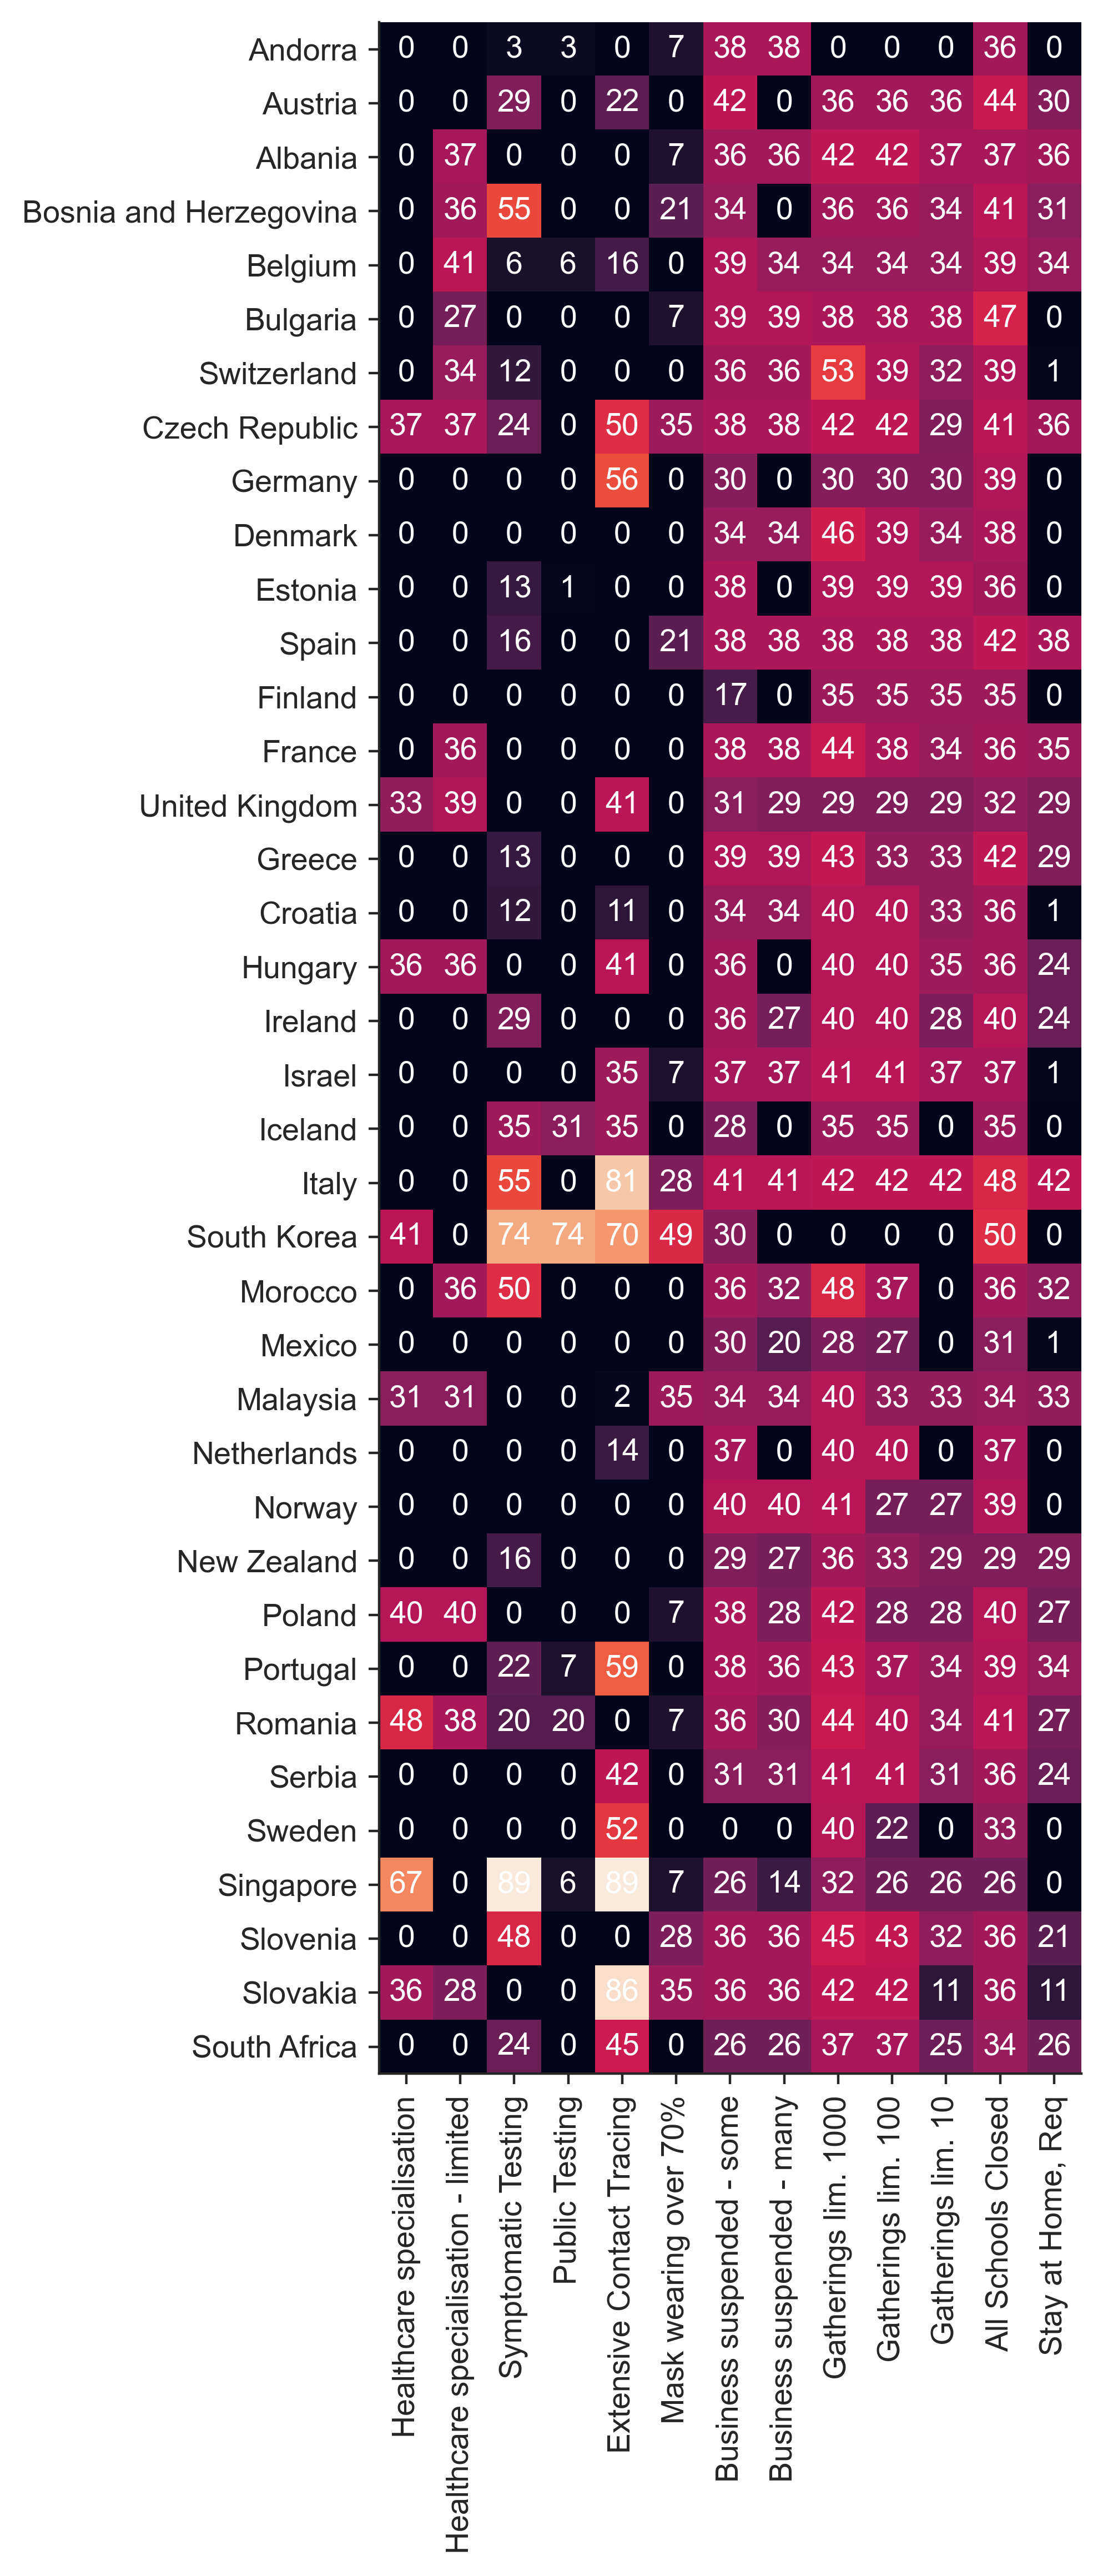

In [73]:
days_active_table = np.zeros(shape=(len(region_info), nCMs))
for d_indx, region in enumerate(region_info):
    for indx, f in enumerate(final_features_ordered):
        days_active_table[d_indx, indx] = np.sum(ActiveCMs[d_indx, indx, :])

fig = plt.figure(figsize=(8.3, 11.7), dpi=400)
plt.imshow(days_active_table)

for r in range(len(region_info)):
    for cm in range(len(final_features_ordered)):
        num = days_active_table[r, cm]
        if num < 90:
            plt.text(cm, r, f"{num:.0f}", color="white", horizontalalignment="center", verticalalignment="center")
        else:
            plt.text(cm, r, f"{num:.0f}", color="black", horizontalalignment="center", verticalalignment="center")

plt.yticks(np.arange(len(region_names)), region_names)
plt.xticks(
    np.arange(len(final_features_ordered)),
    [f for f in final_features_ordered],
    rotation=90
)
sns.despine()
plt.ylim([len(region_info)-0.5, -0.5])
plt.tight_layout()
plt.savefig("table.pdf")

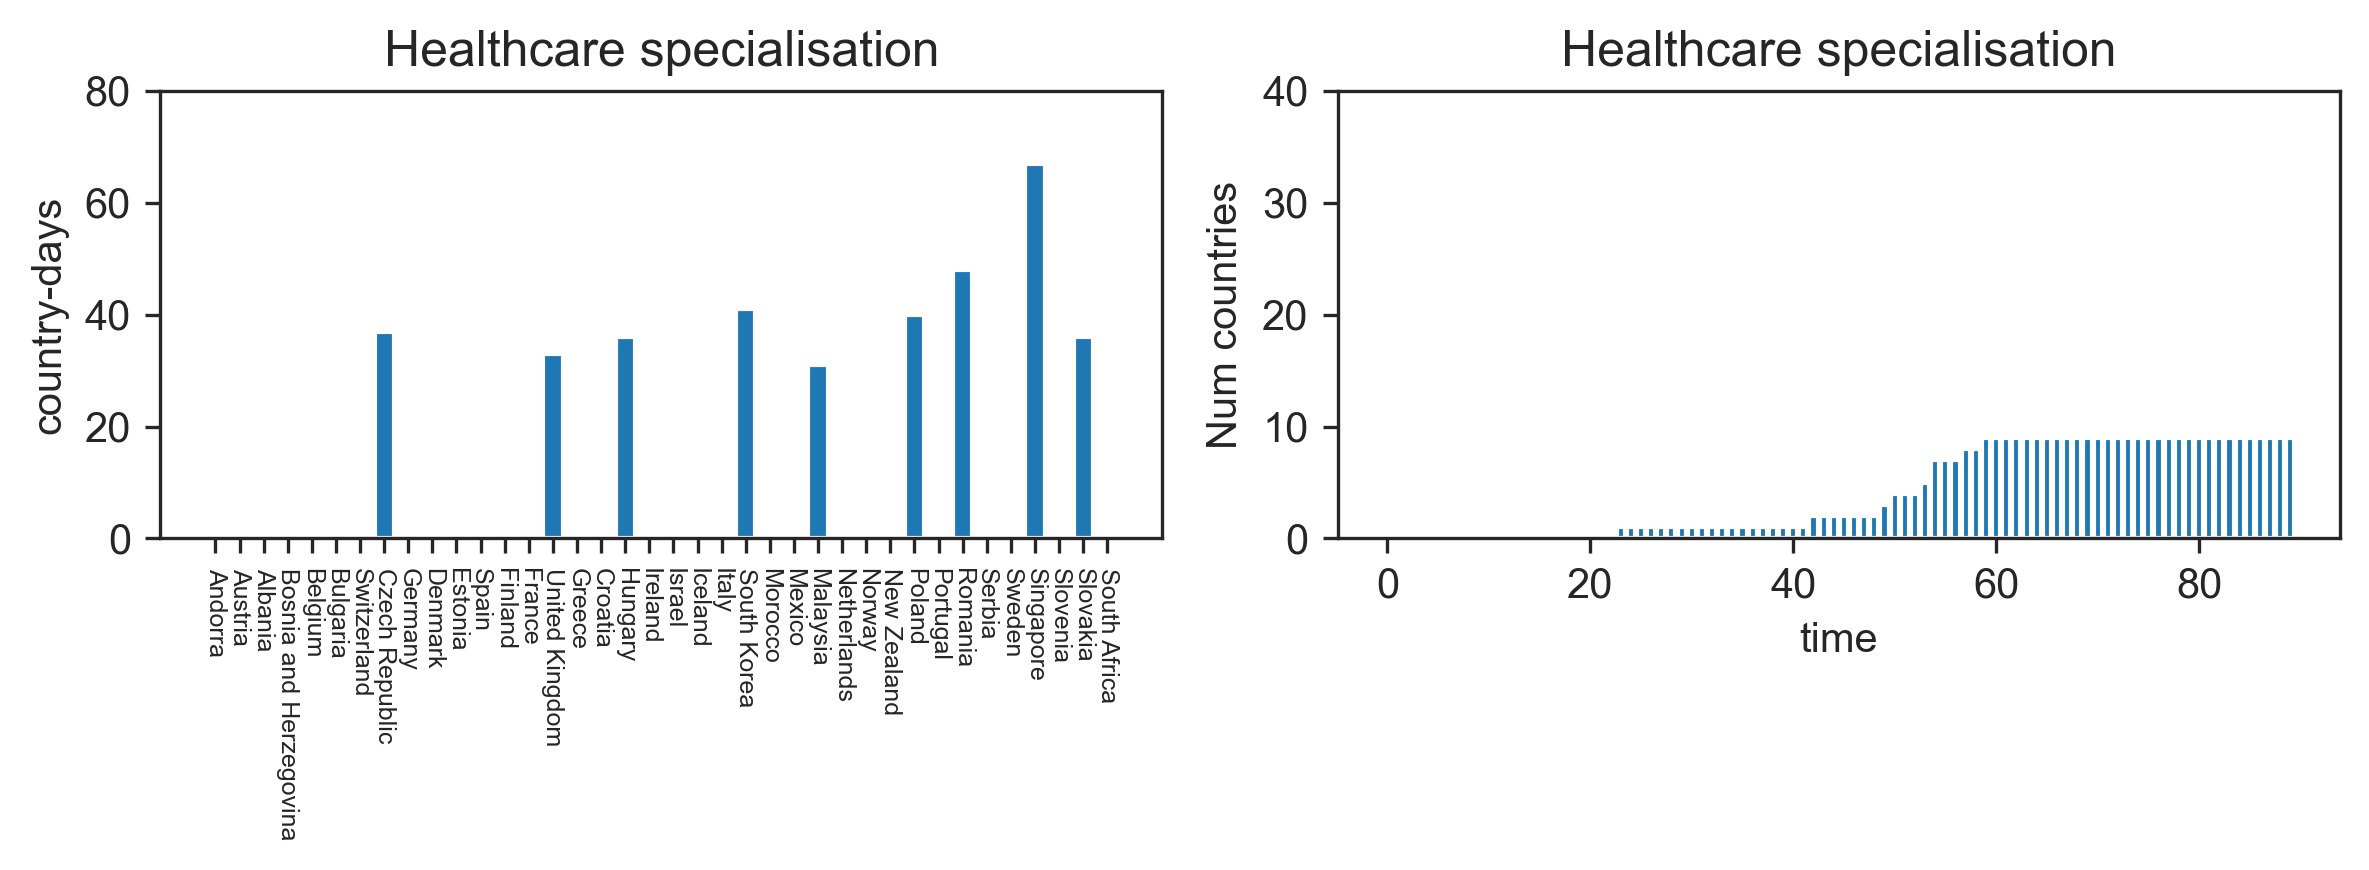

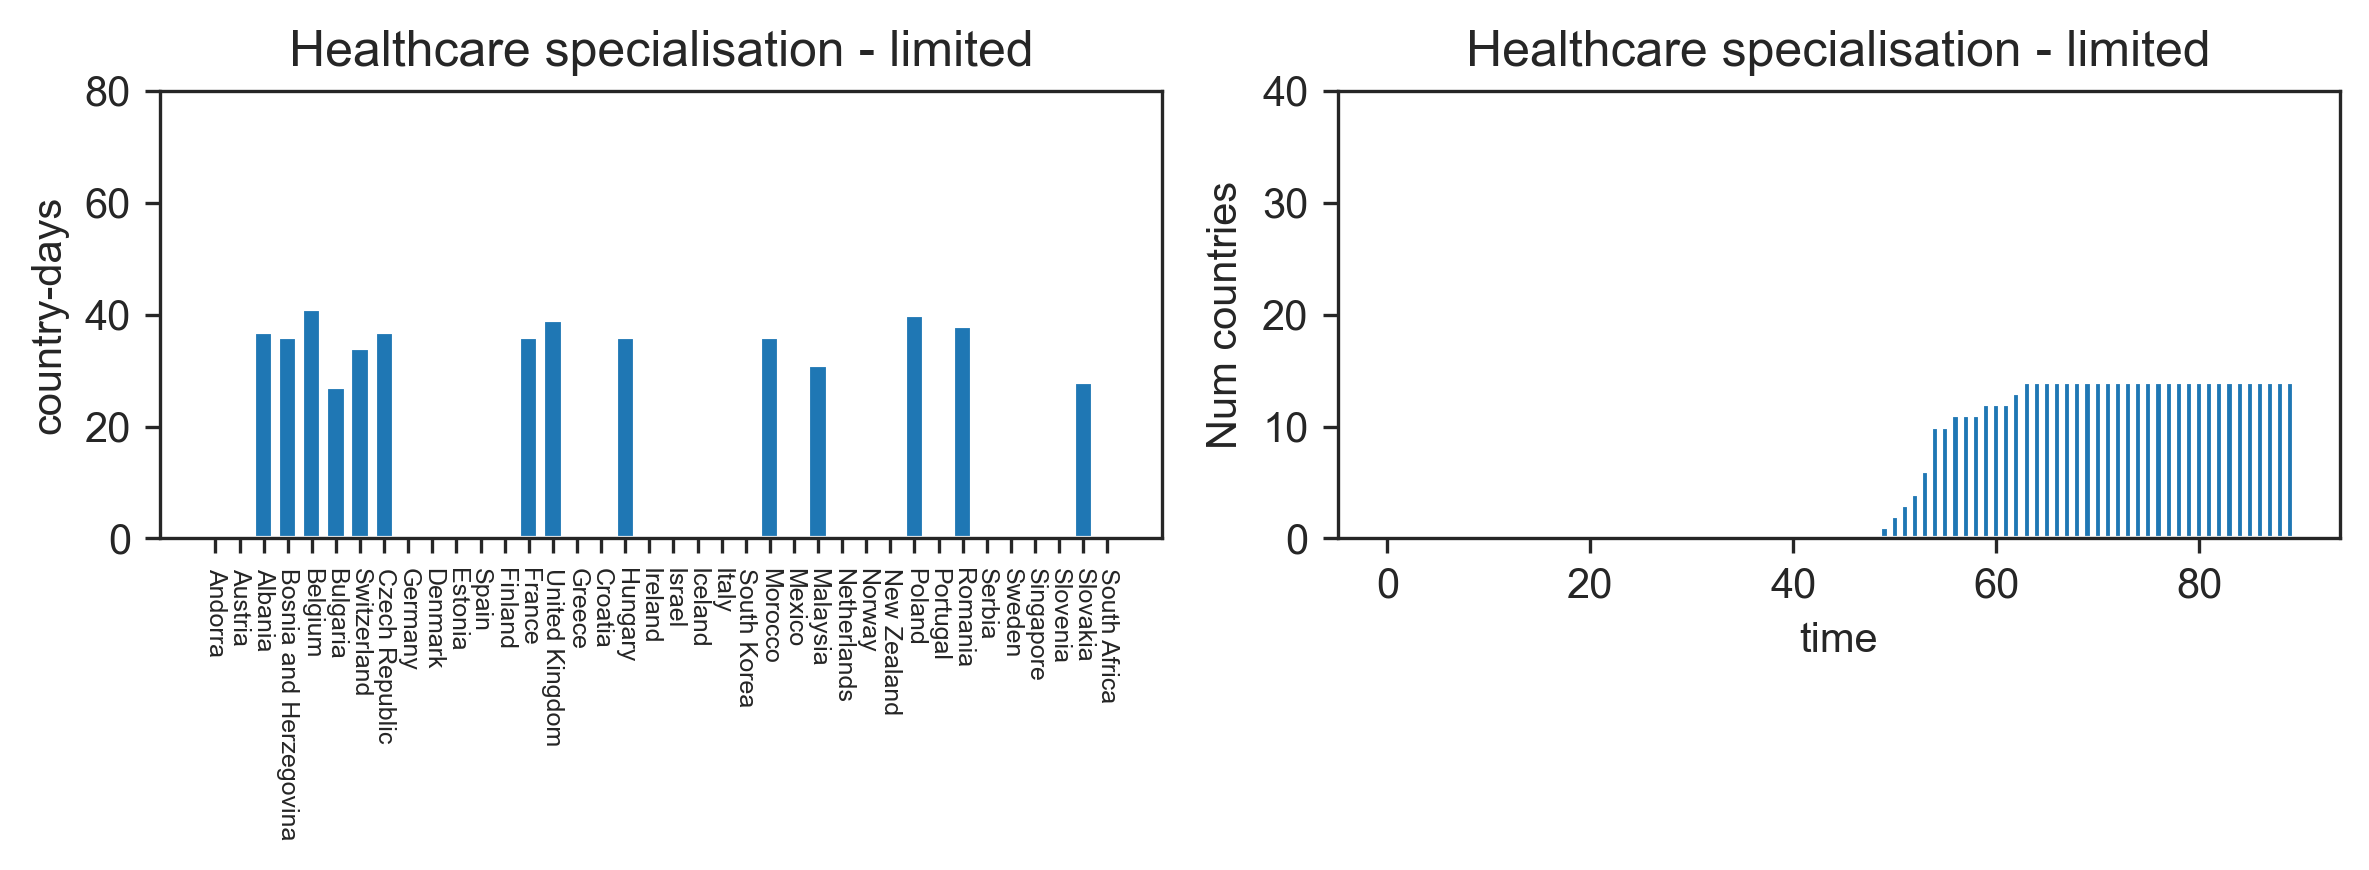

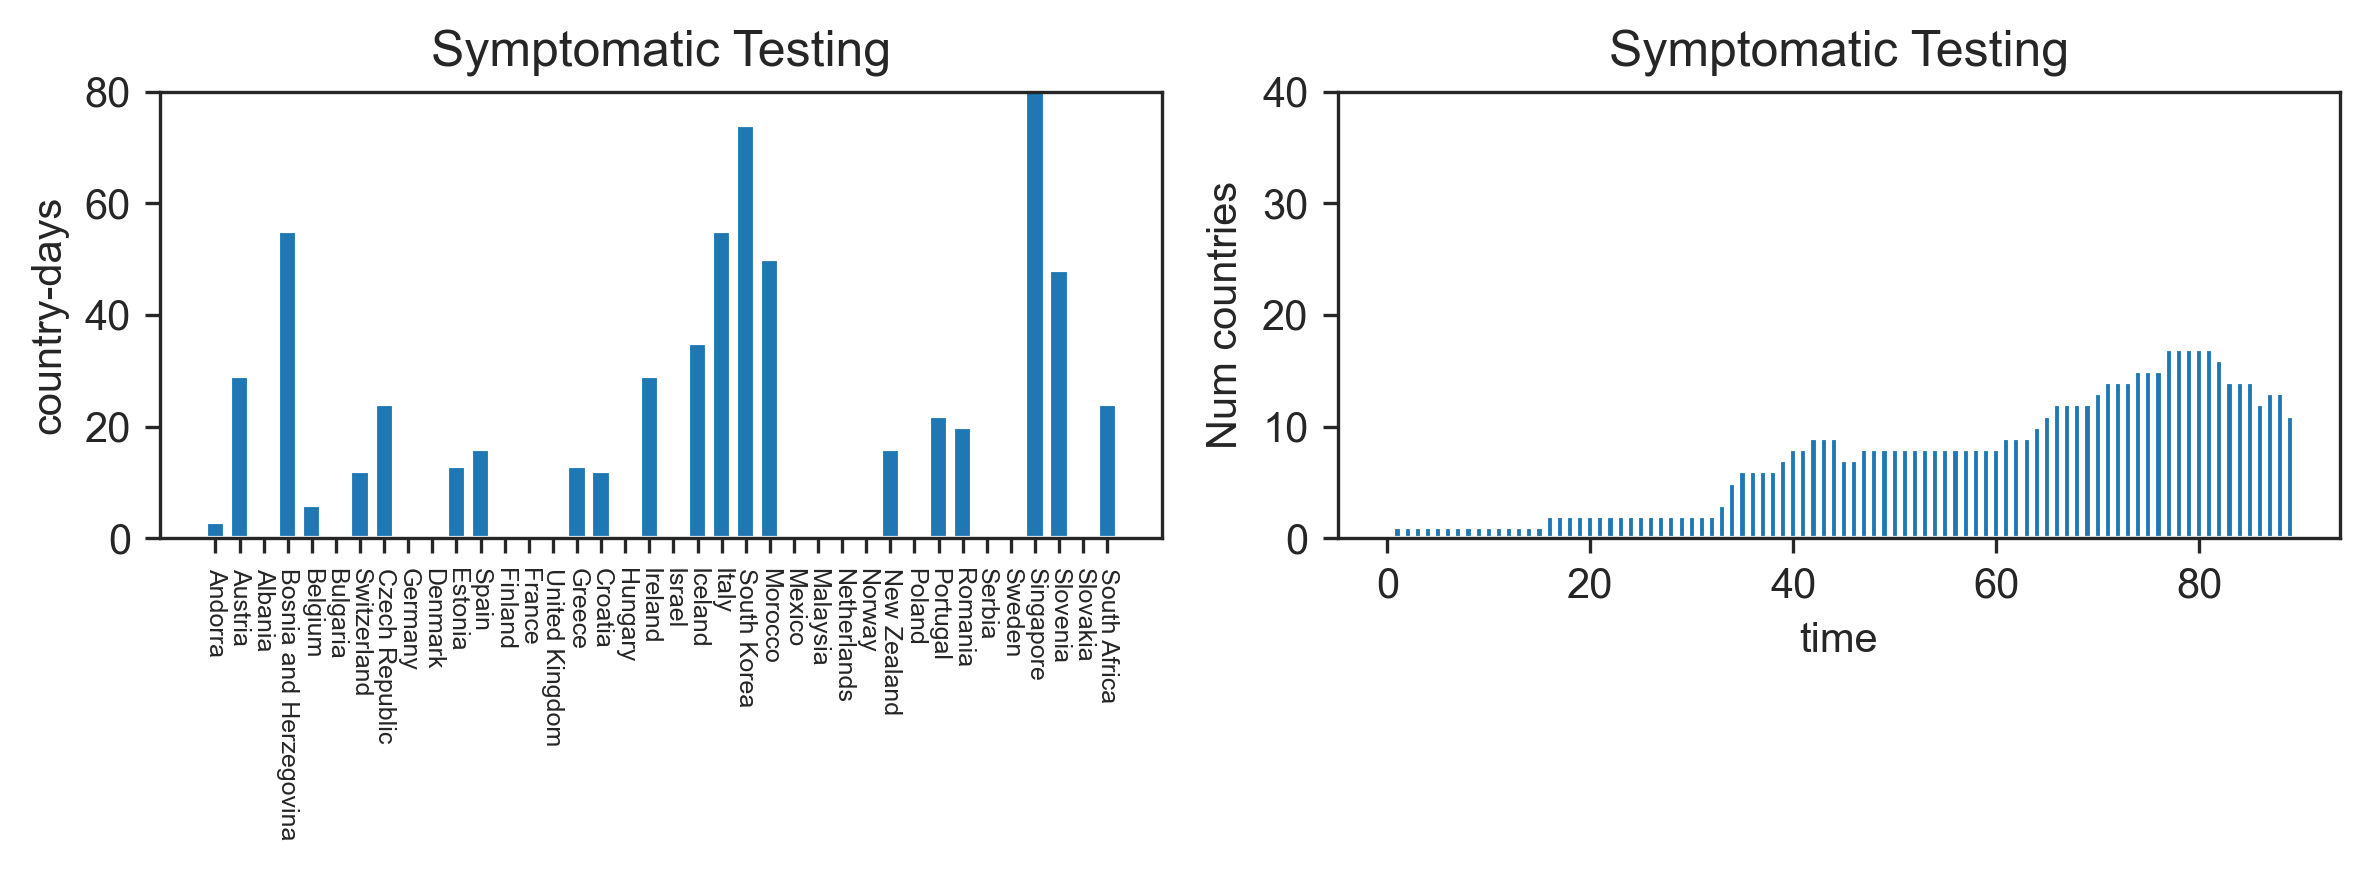

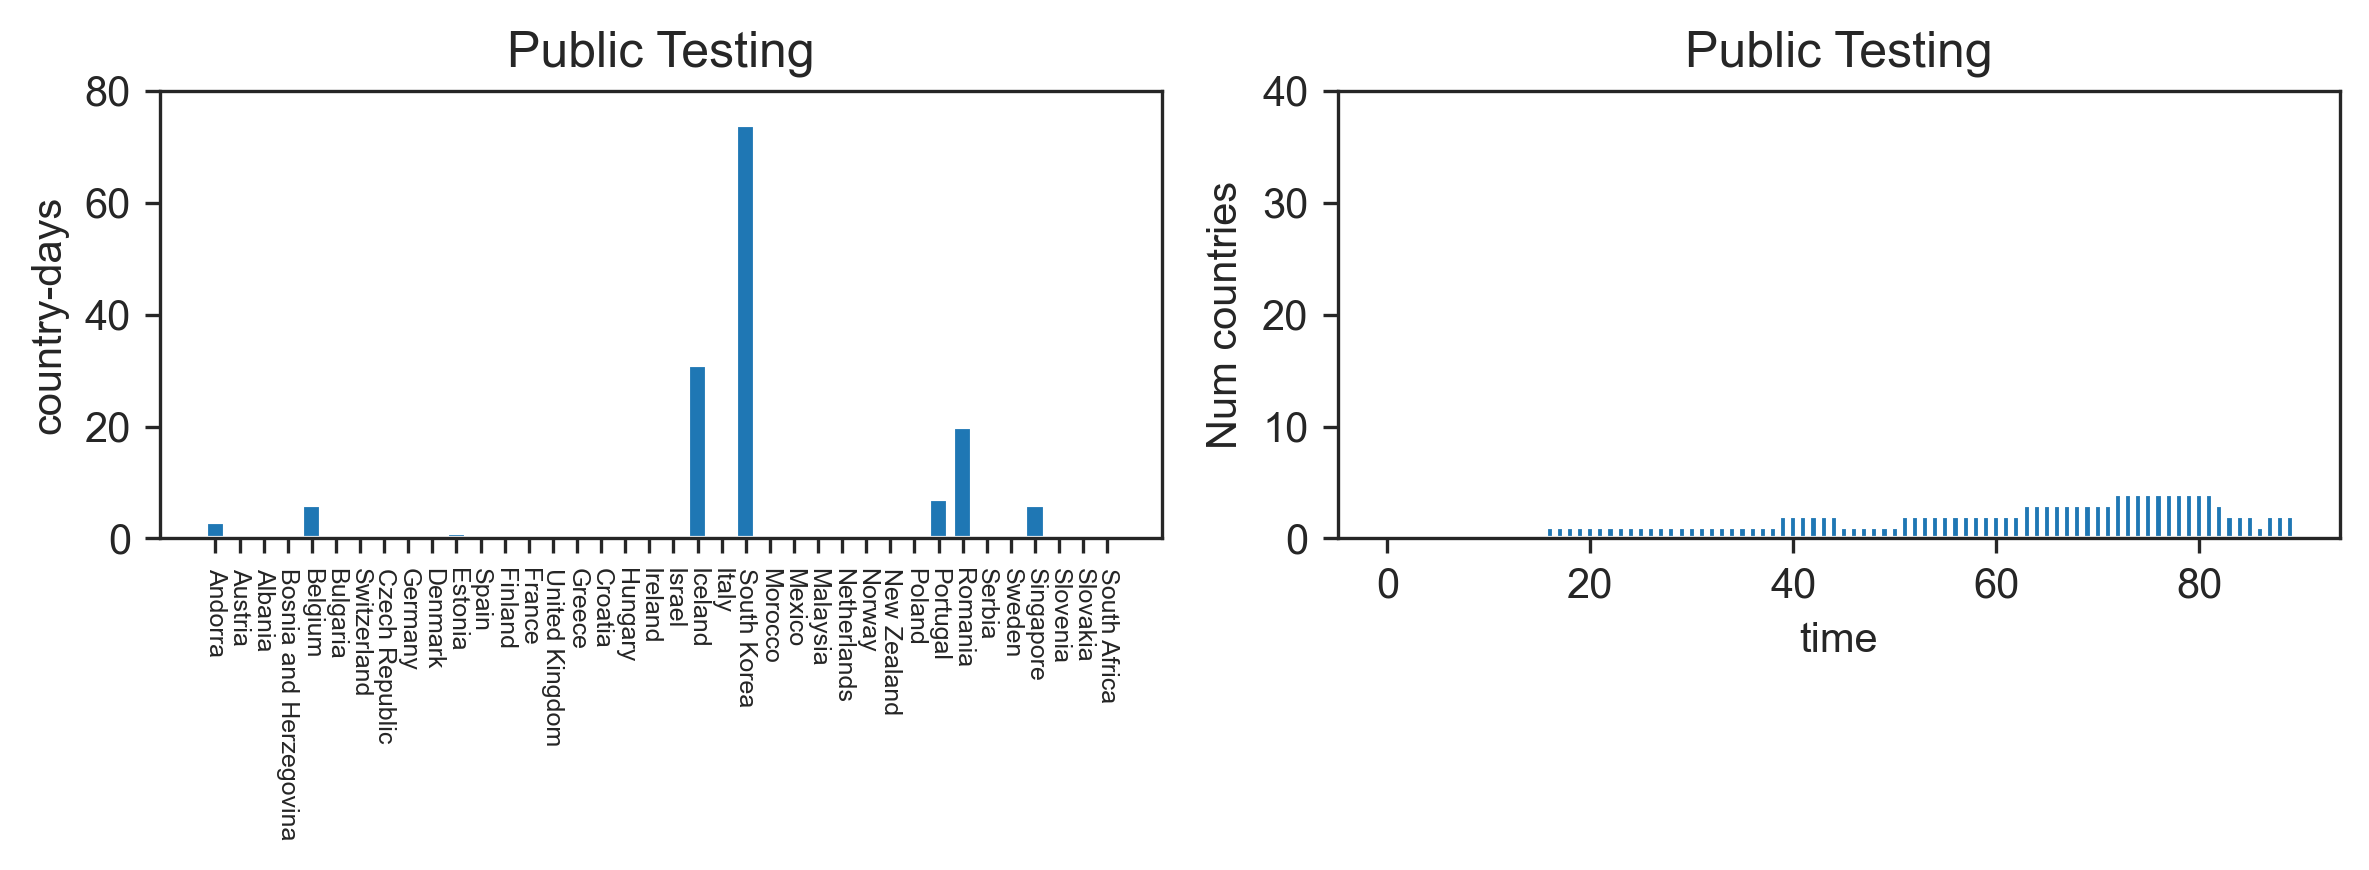

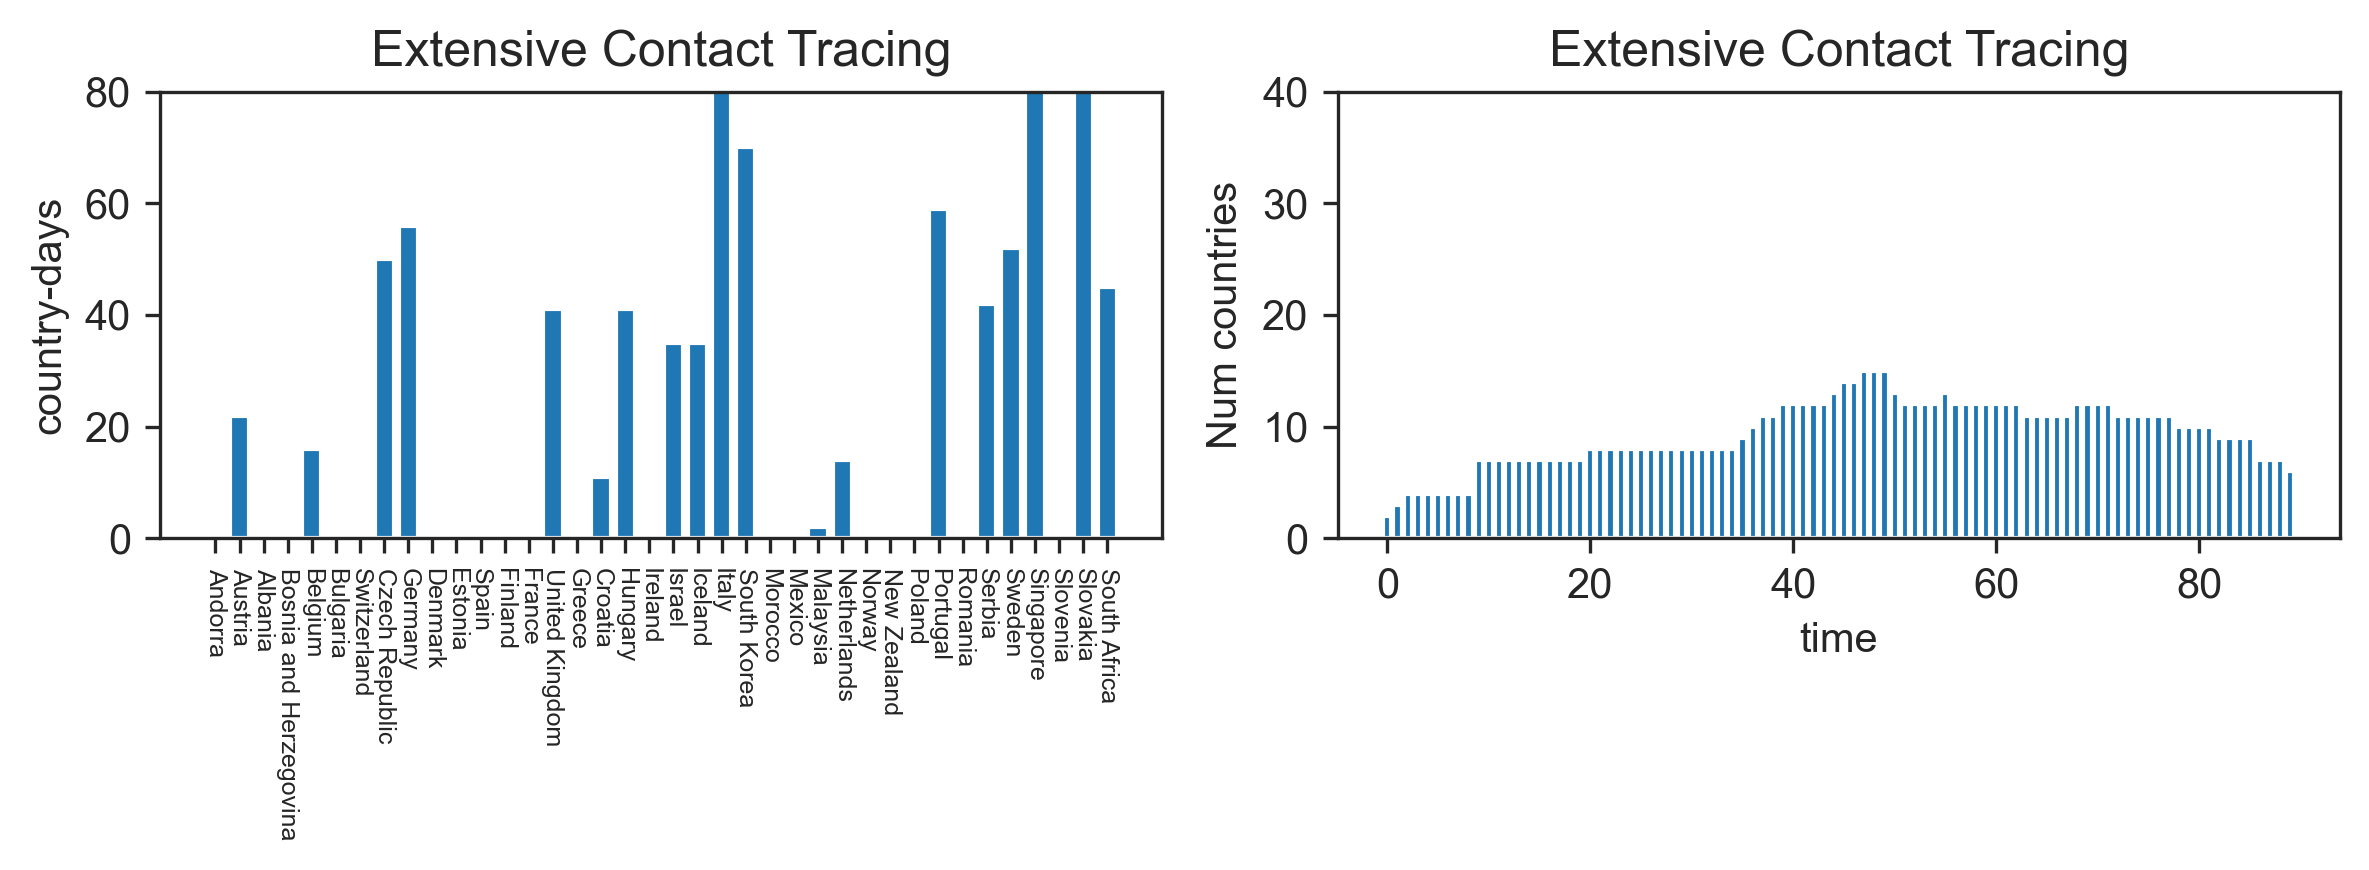

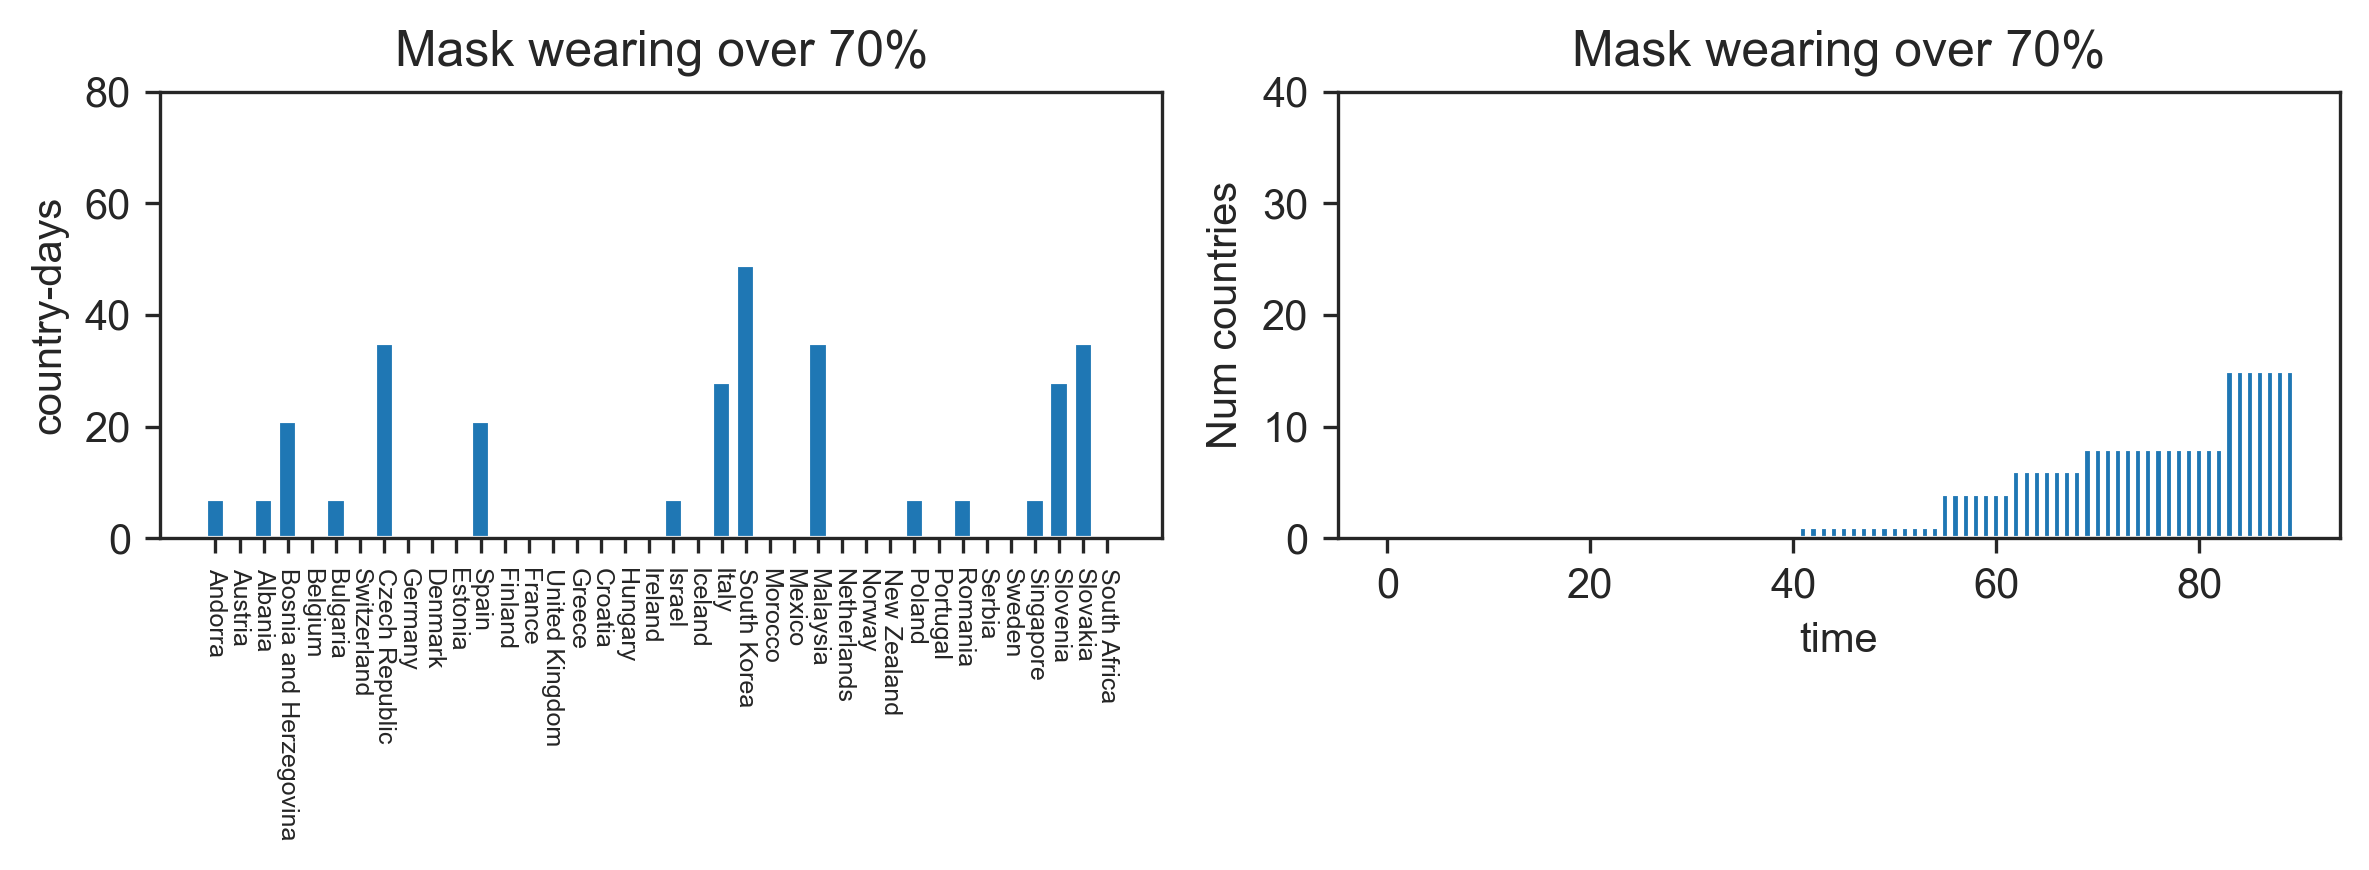

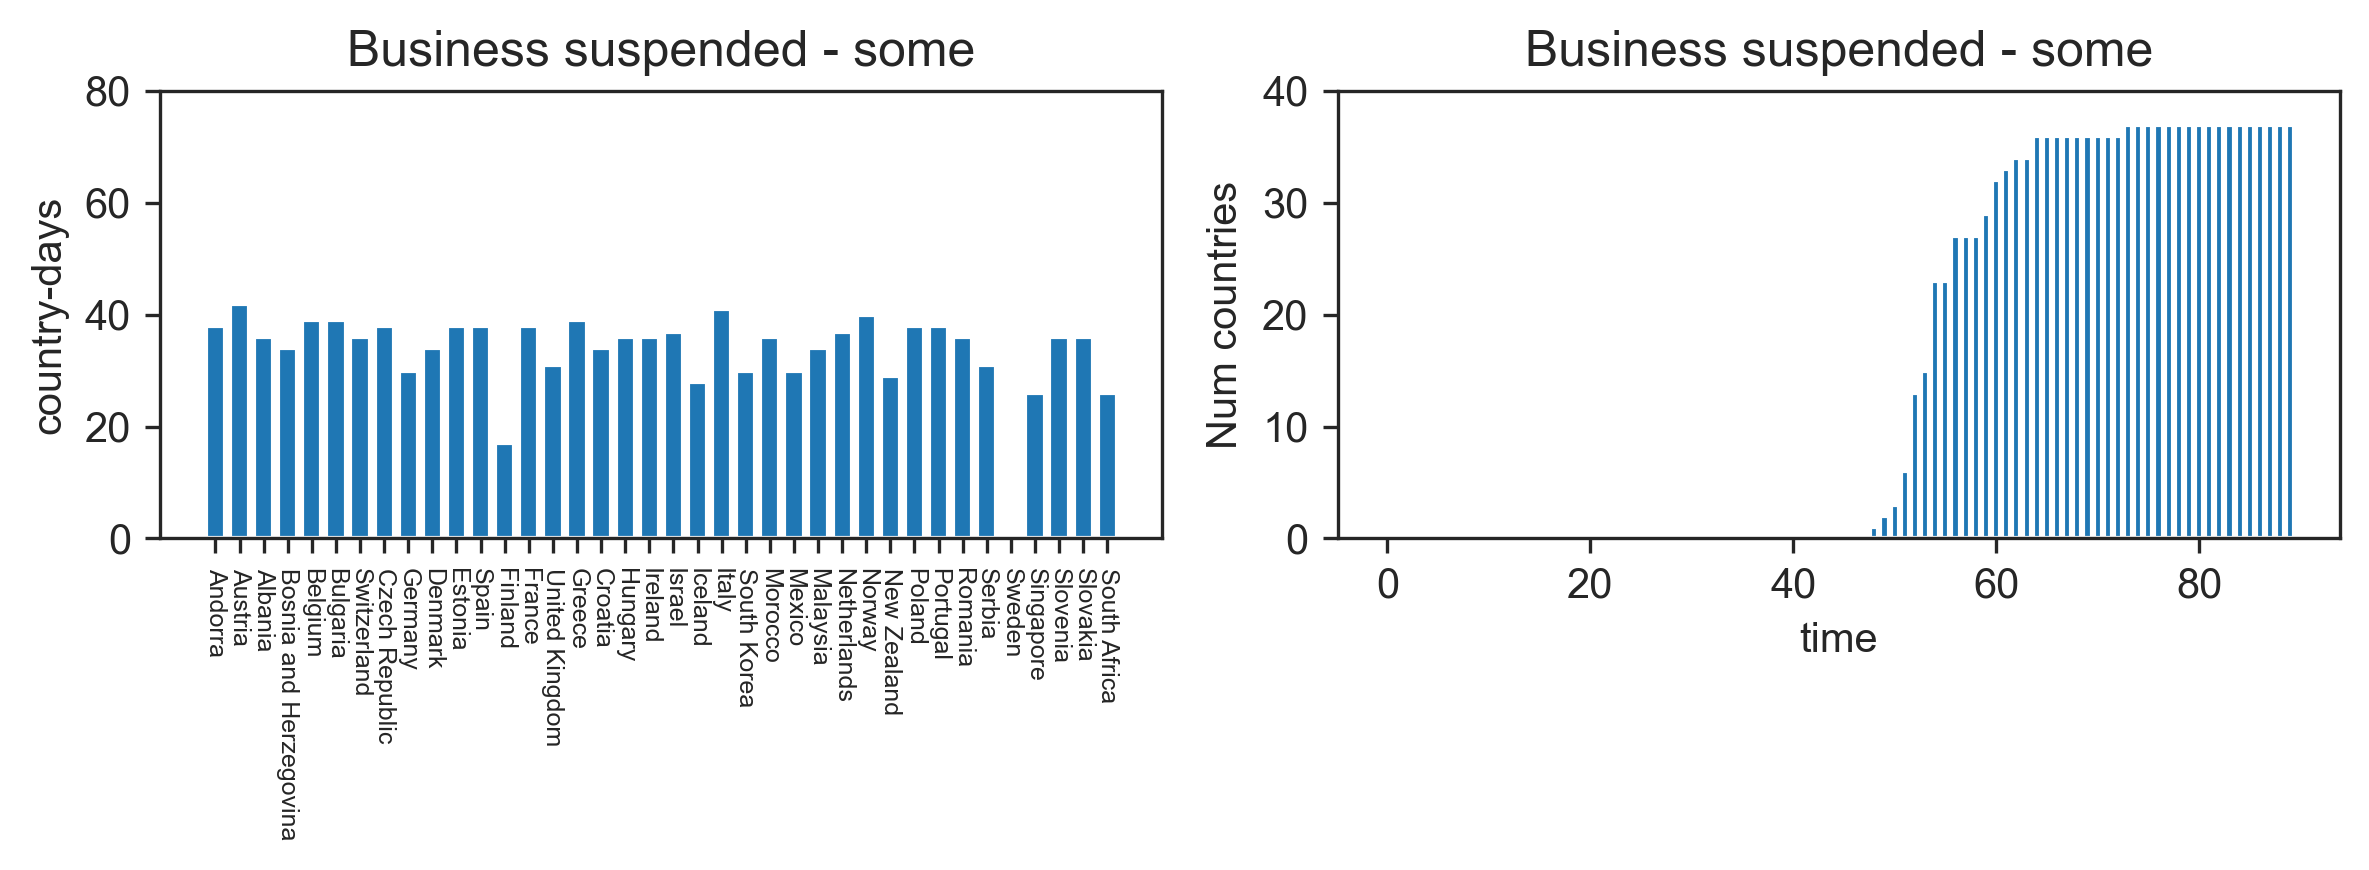

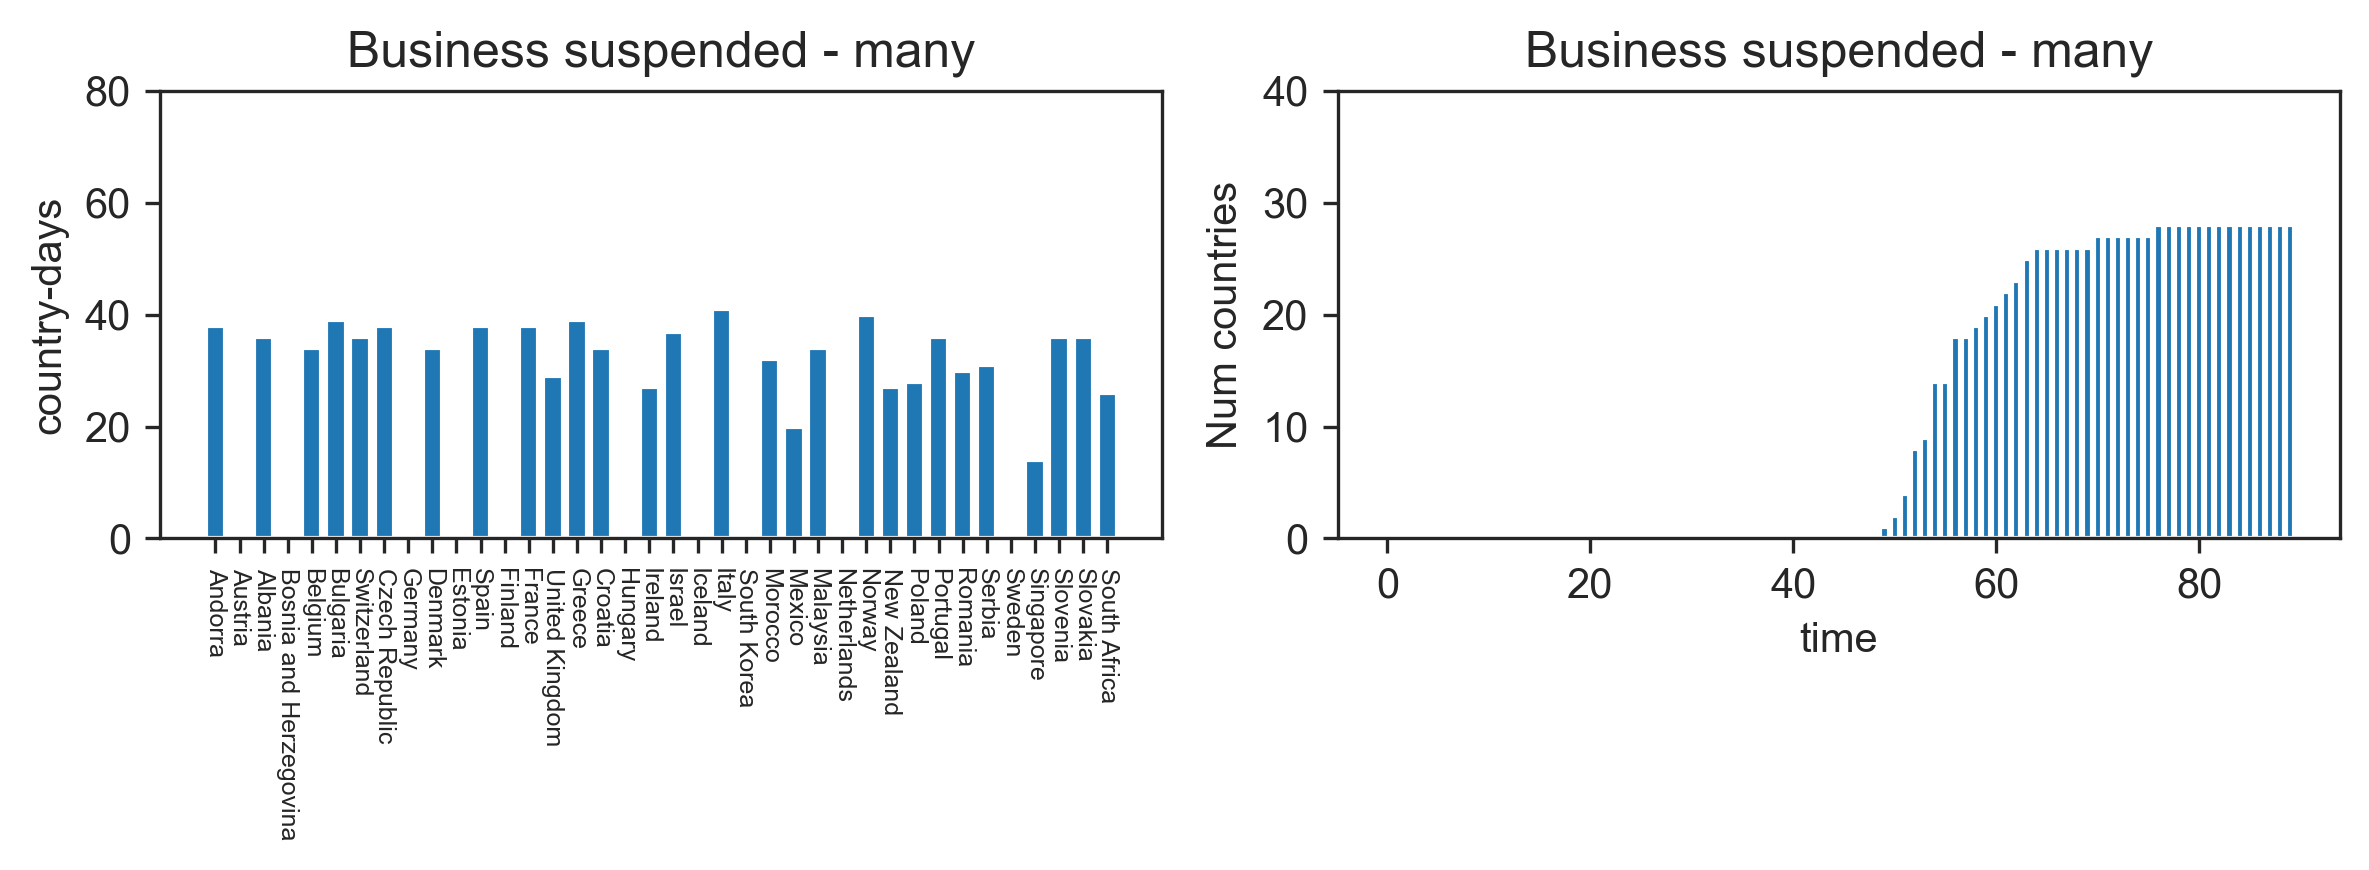

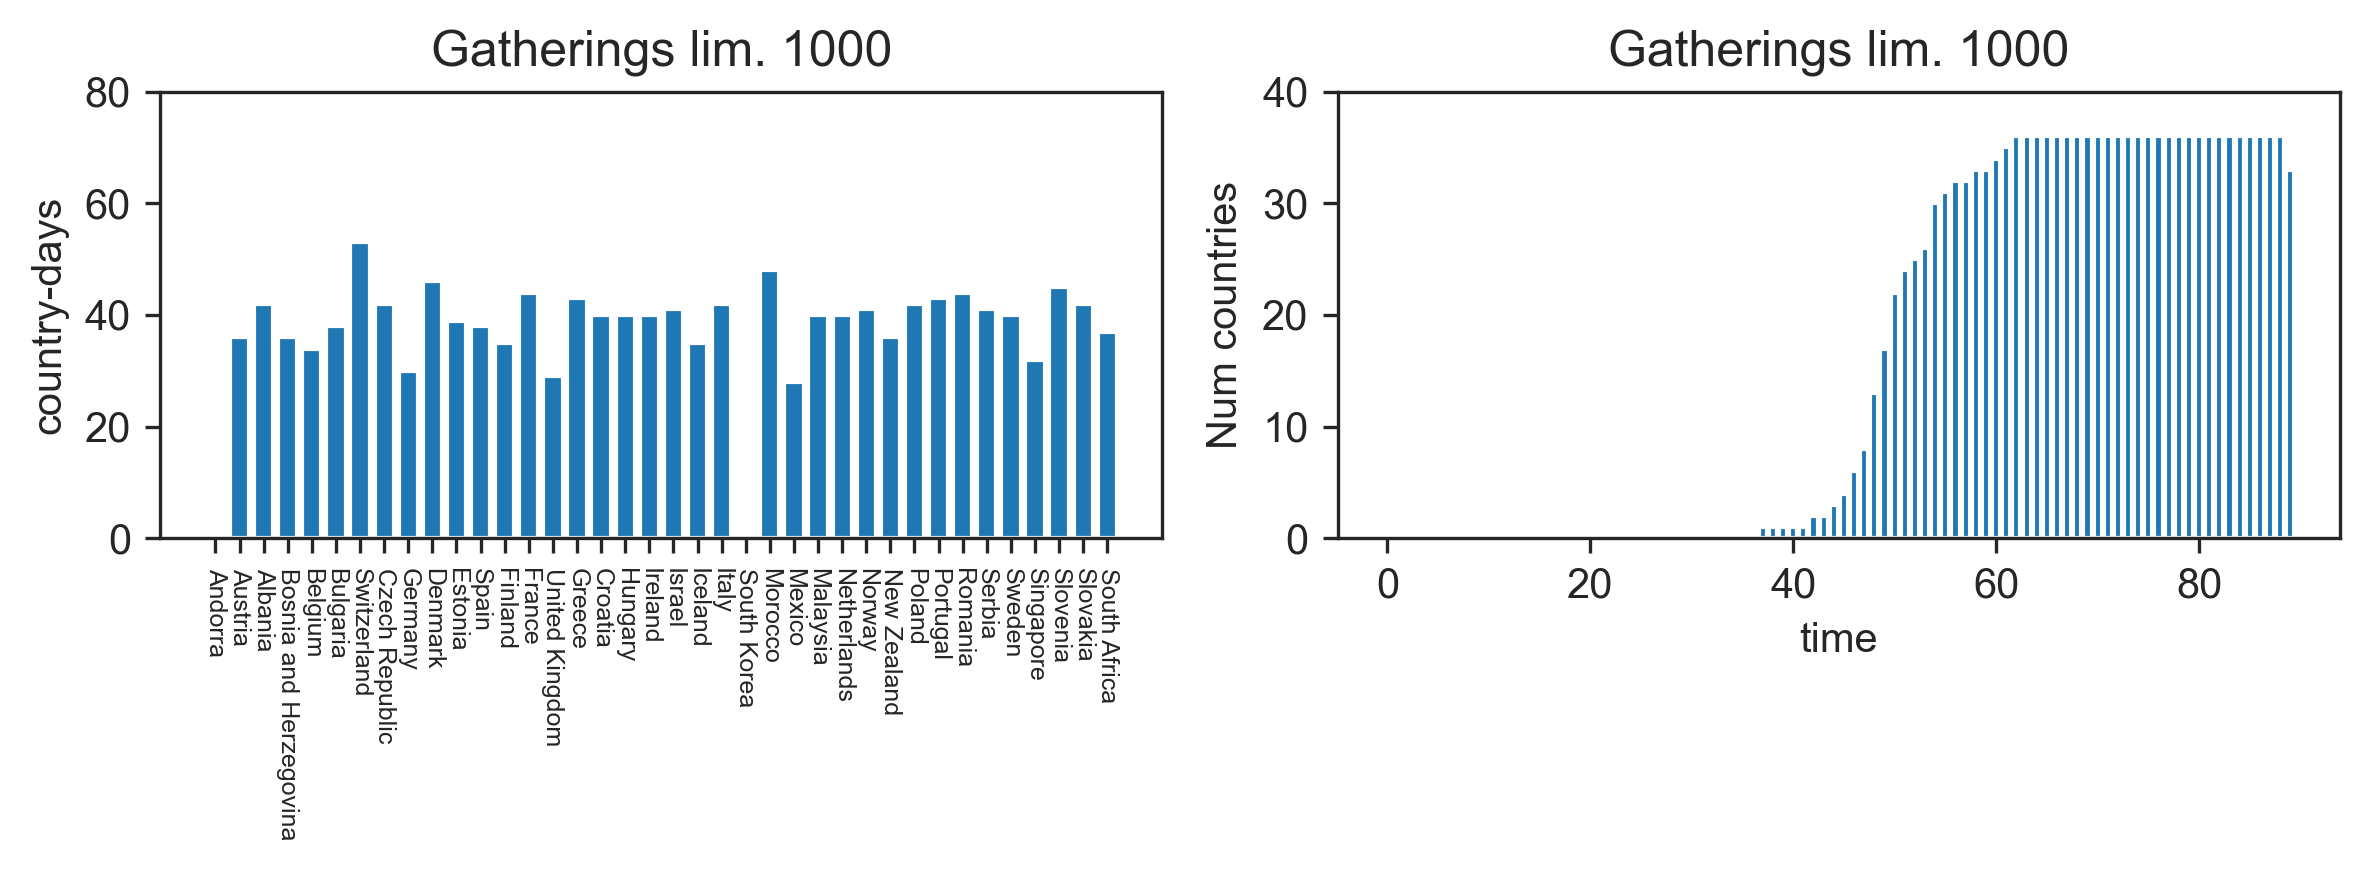

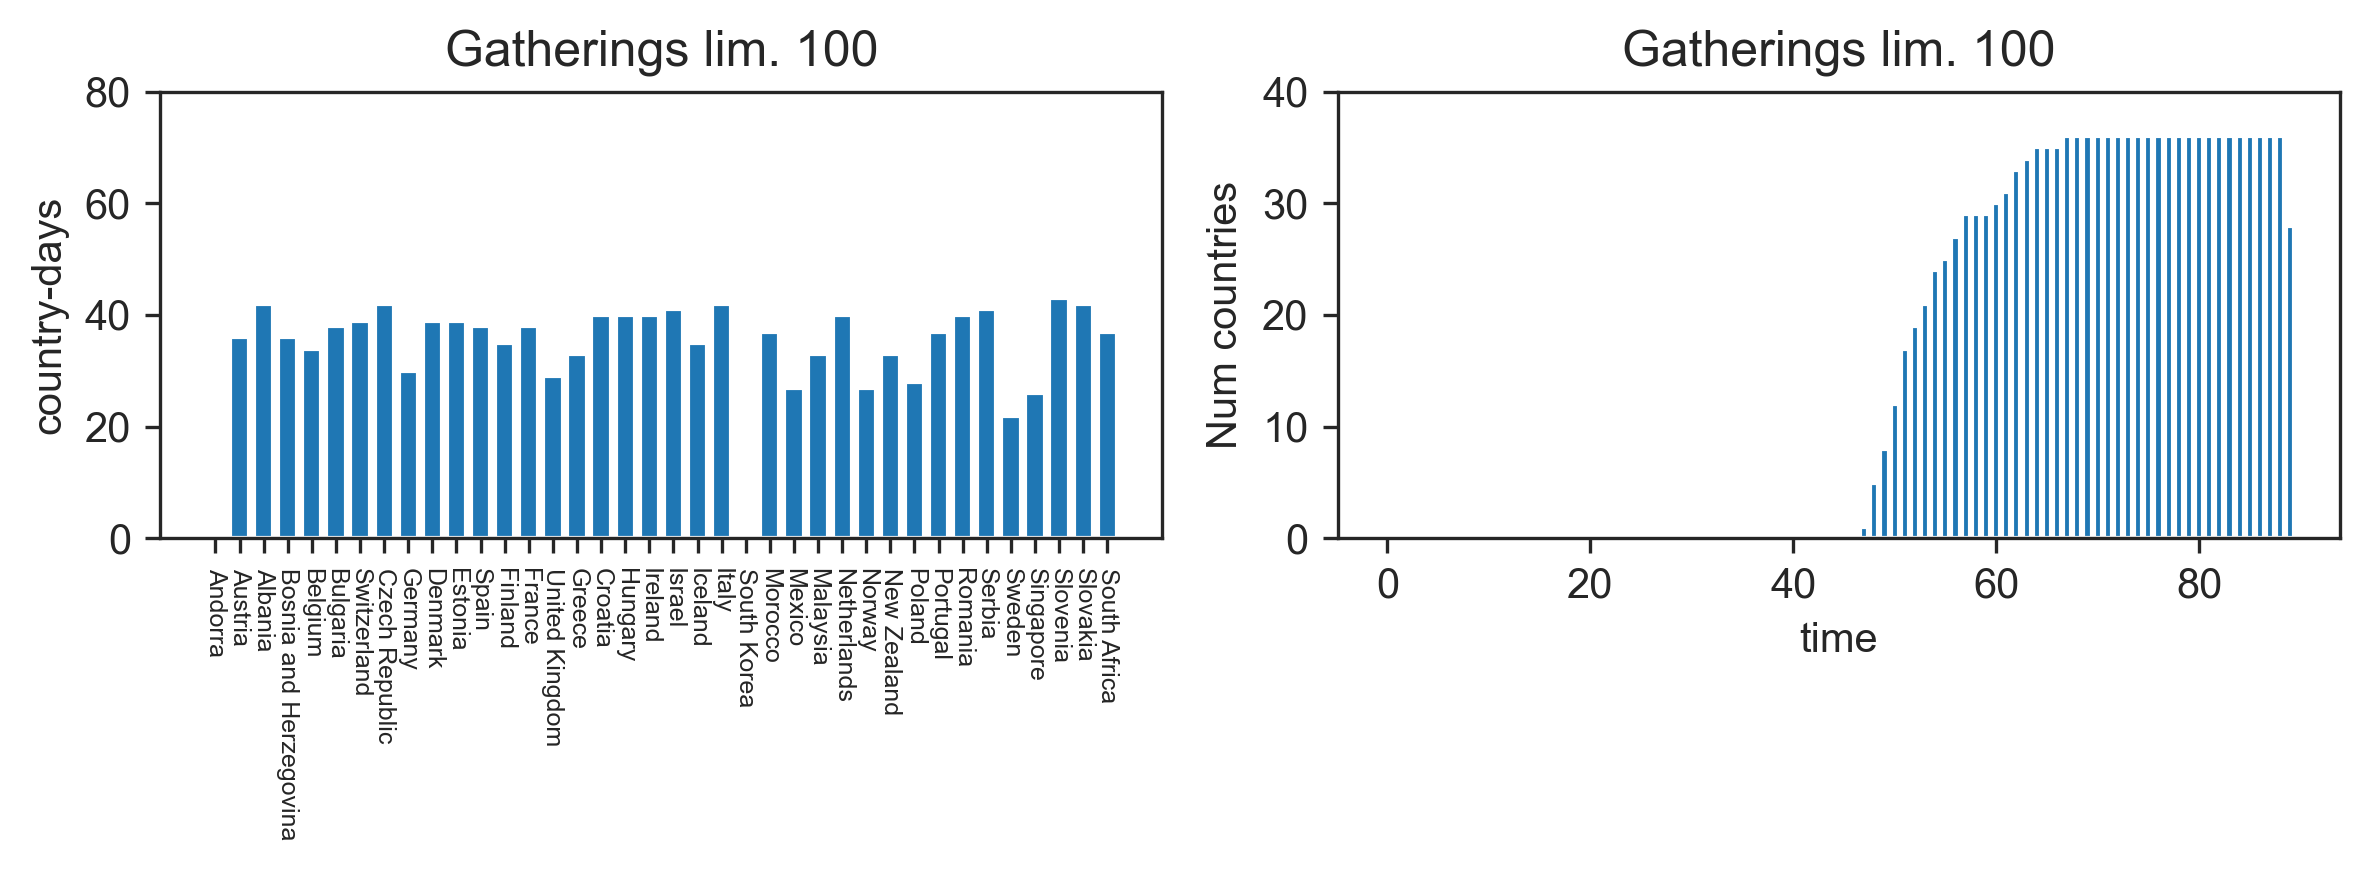

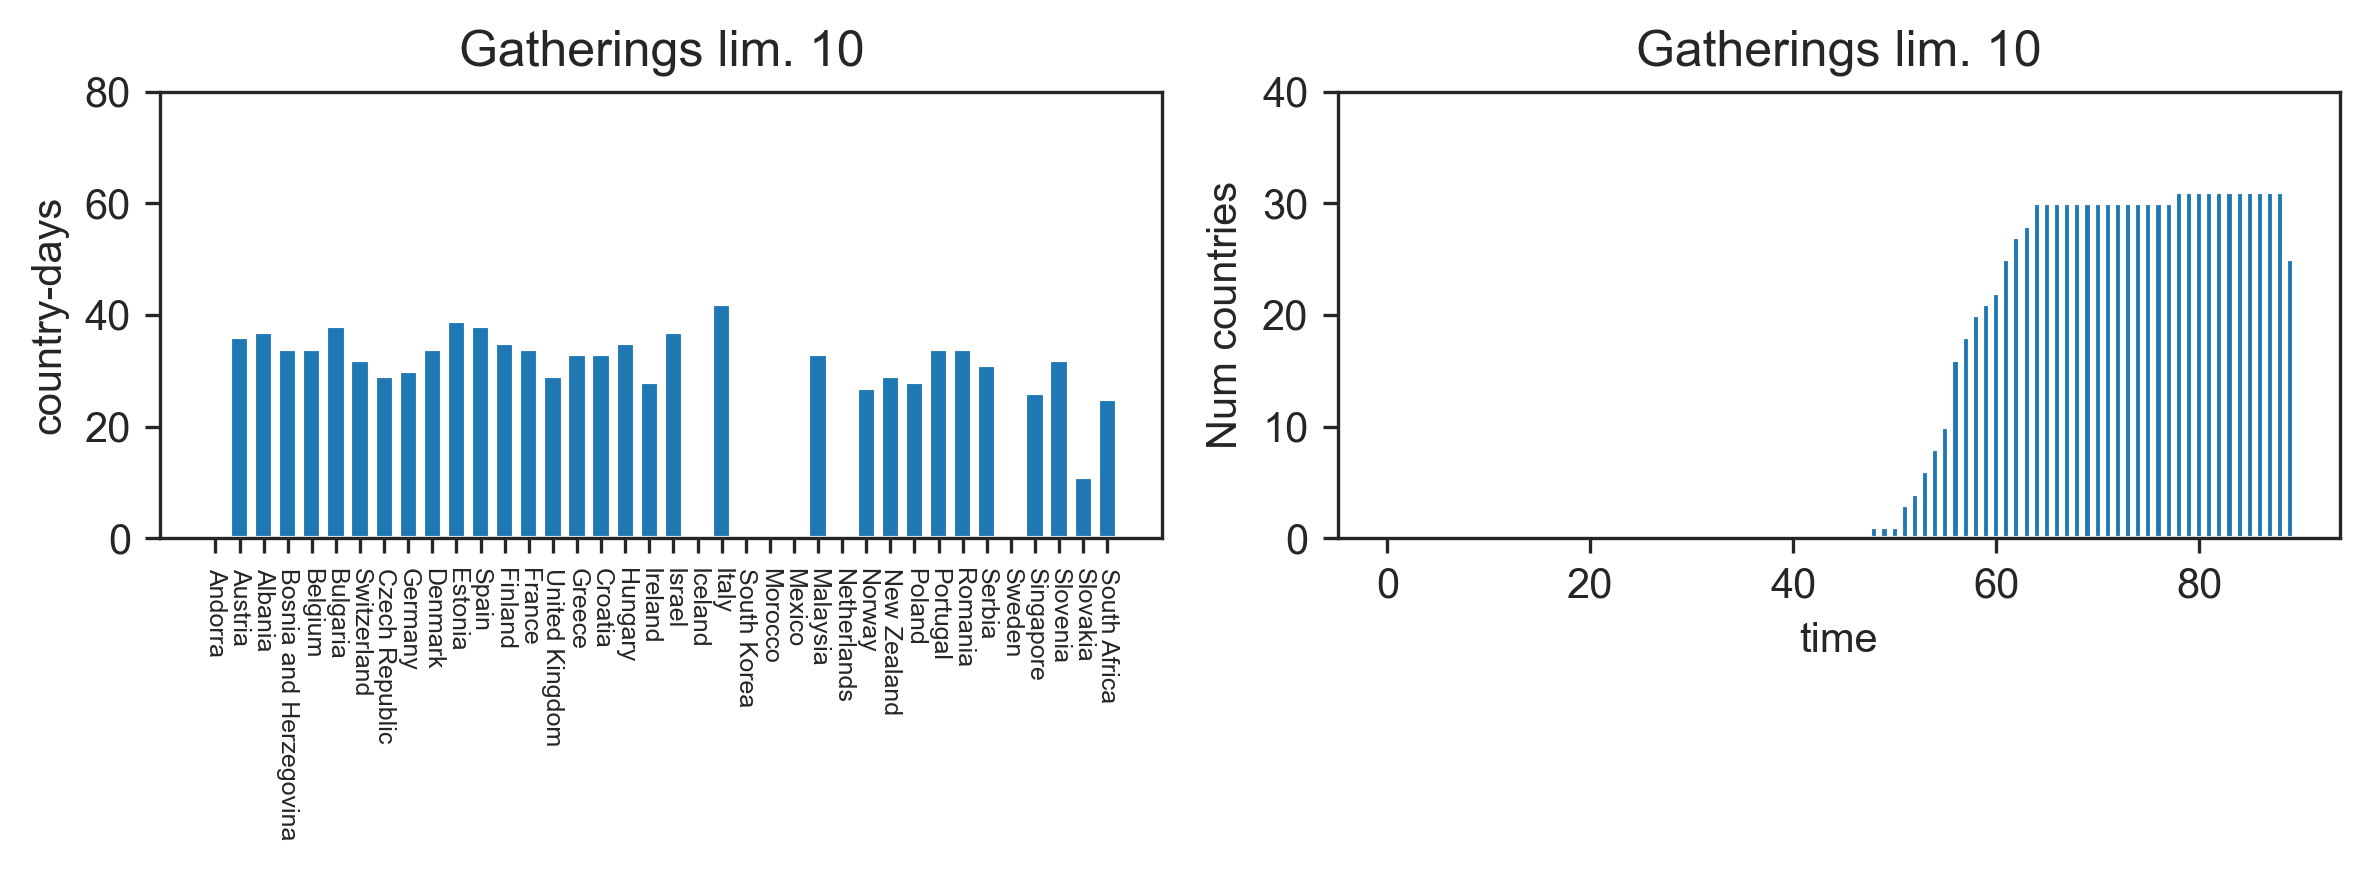

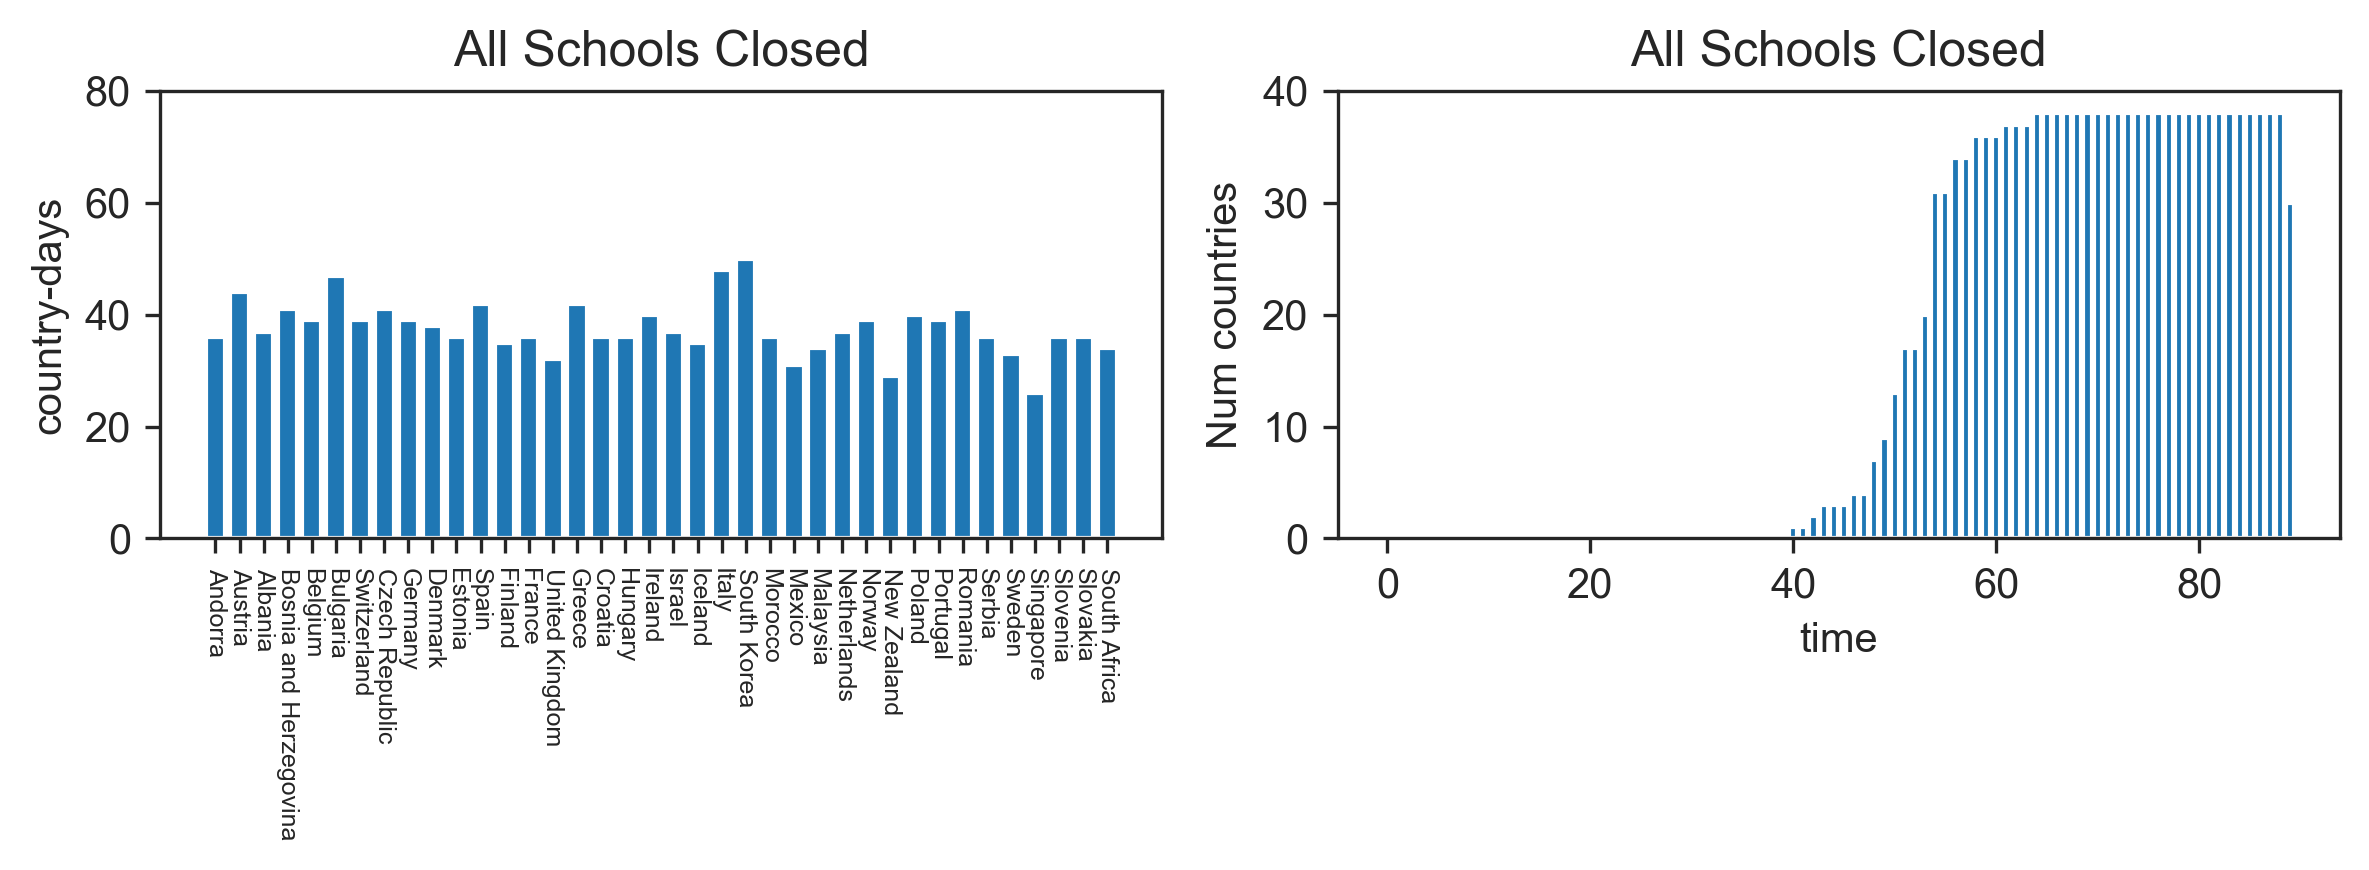

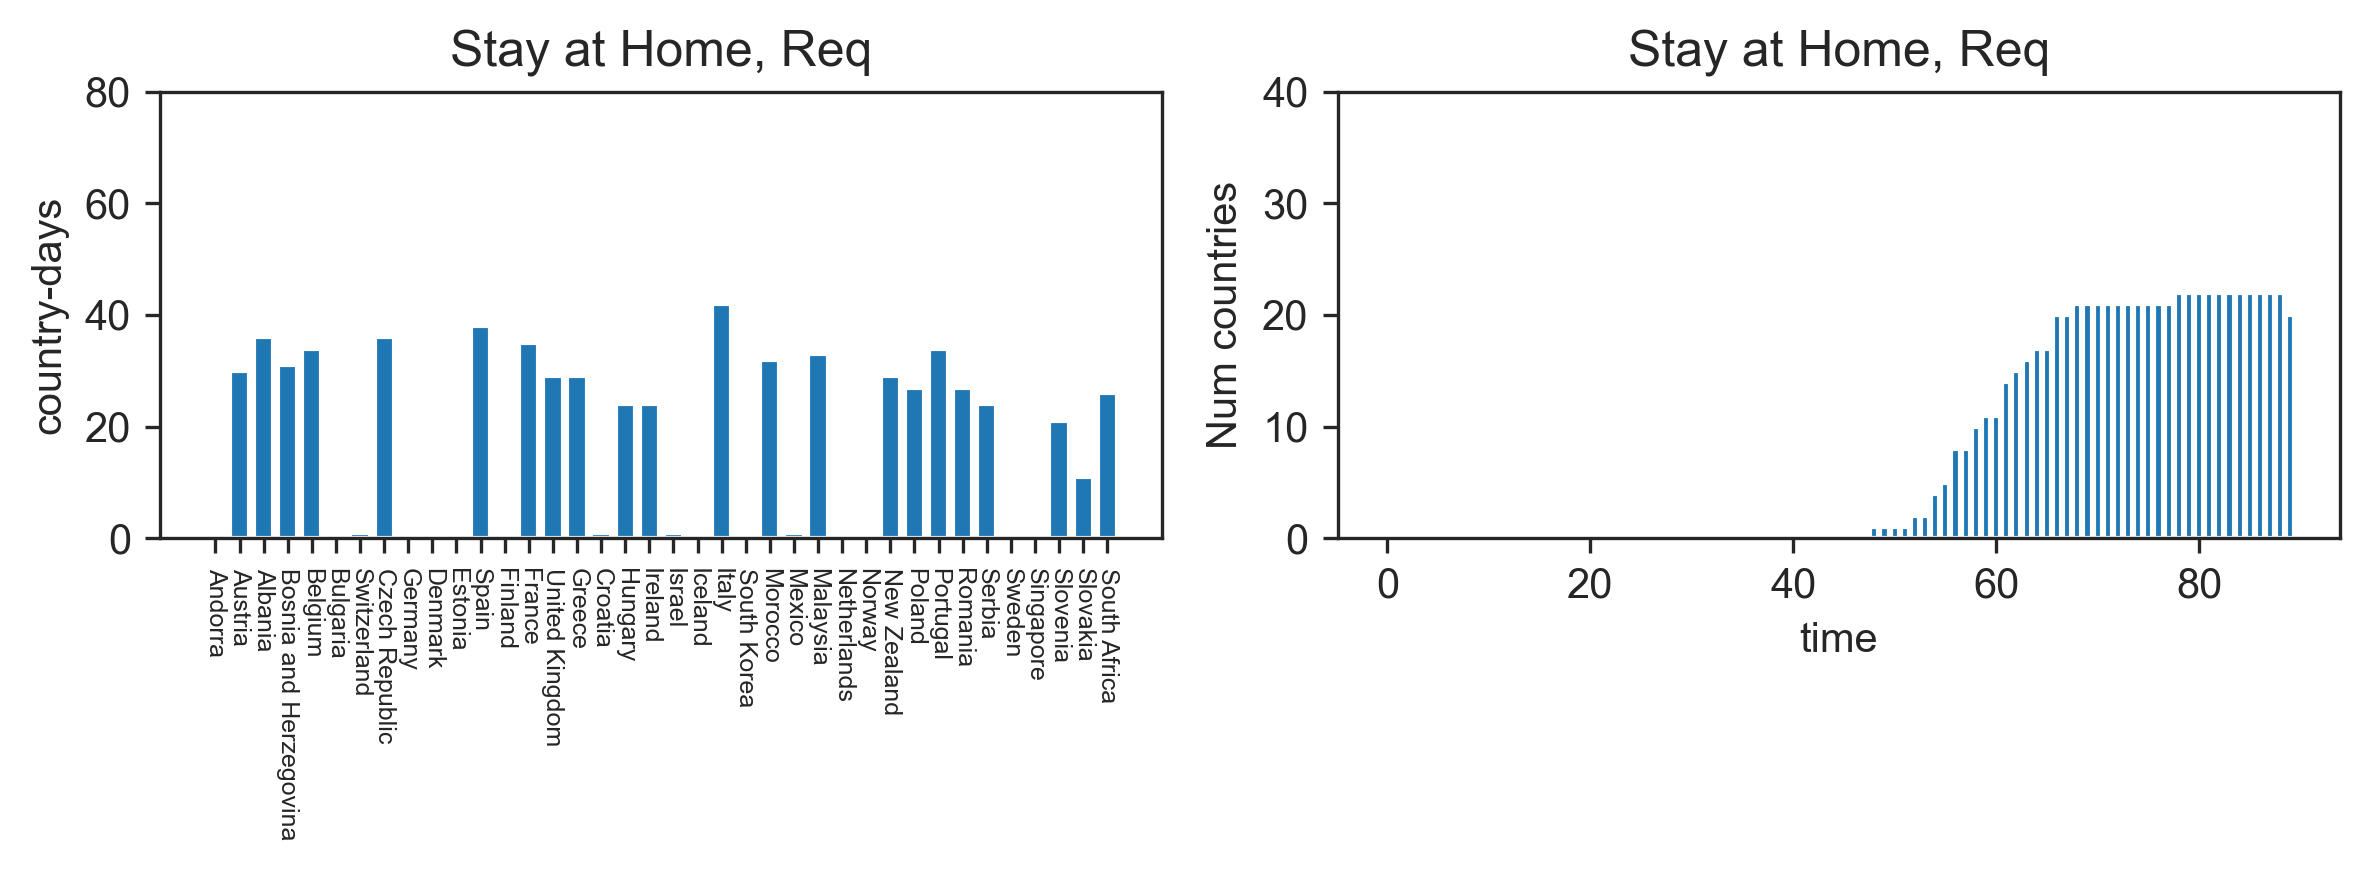

In [74]:
for indx, cm in enumerate(final_features_ordered):
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=1)
    plt.figure(figsize=(8, 3), dpi=300)
    plt.subplot(121)
    plt.bar(np.arange(len(region_names)), hist_data)
    plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
    plt.ylim([0, 80])
    plt.ylabel("country-days")
    plt.title(cm)
    plt.subplot(122)
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=0)
    plt.bar(np.arange(hist_data.size), hist_data)
    plt.title(cm)
    plt.ylim([0, 40])
    plt.ylabel("Num countries")
    plt.xlabel("time")
    plt.tight_layout()

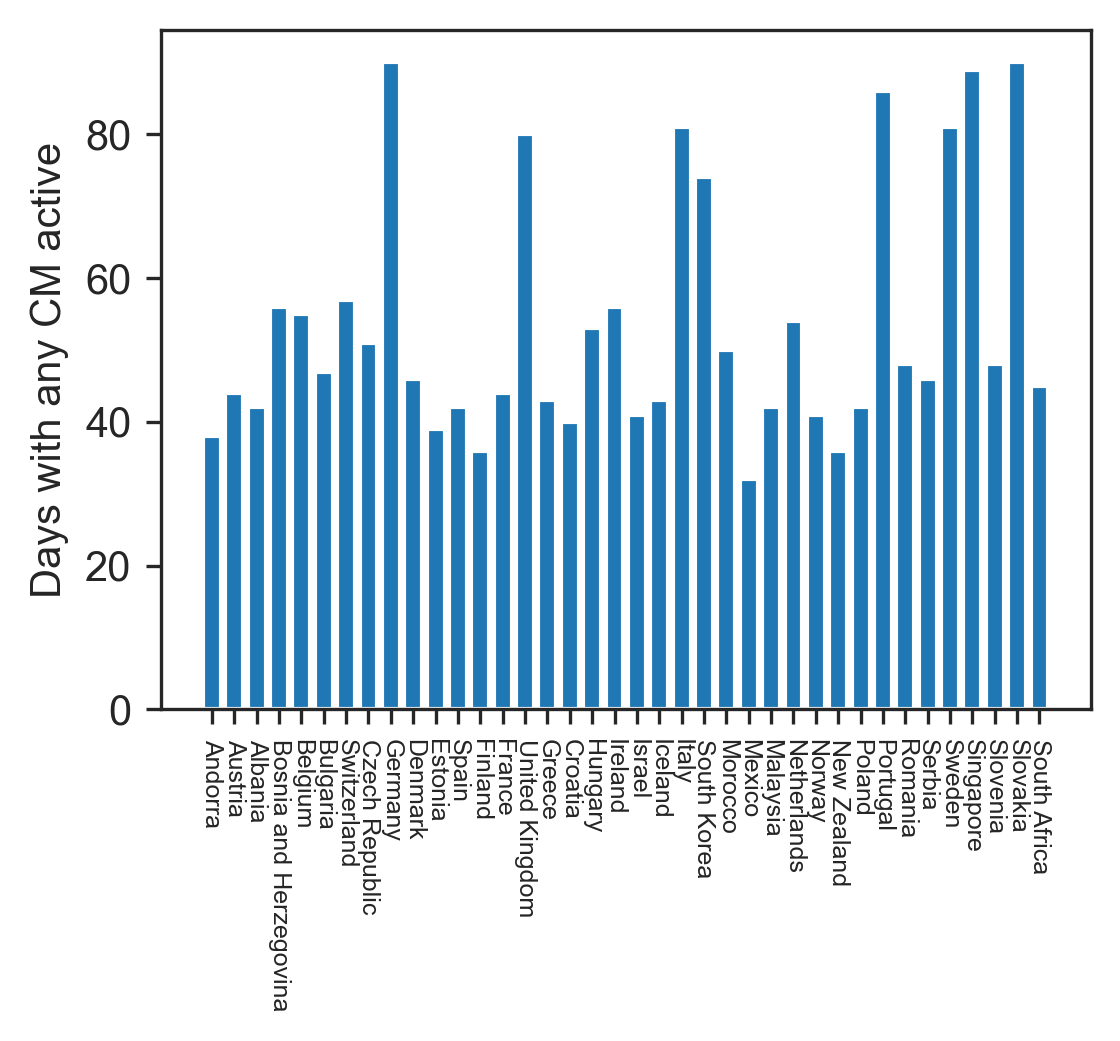

In [75]:
plt.figure(figsize=(4, 3), dpi=300)
cs = np.sum(np.sum(ActiveCMs[:, :, :], axis=1) > 0, axis=-1)
plt.bar(np.arange(len(region_names)), cs)
plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
plt.ylabel("Days with any CM active");

In [116]:
from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"/Users/mrinank/workspace/fonts/Font Awesome 5 Free-Solid-900.otf")

final_features_ordered = [
    'Healthcare specialisation - limited', 
    "Healthcare specialisation", 
    "Symptomatic Testing",
    "Public Testing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    "Gatherings lim. 1000",    
    "Gatherings lim. 100",
    "Gatherings lim. 10",
    "All Schools Closed",
    "Stay at Home, Req"
]

display_with = [
    [1], [], [3], [], 
    [], [], [7], [], 
    [9, 10], [10], [], [], [] 
]


plot_style = [
            ("\uf7f2", "tomato"),
            ("\uf7f2", "tab:red"),
            ("\uf492", "lightskyblue"),
            ("\uf492", "mediumblue"),
            ("\uf002", "black"),
            ("\uf963", "black"),
            ("\uf07a", "tab:orange"),
            ("\uf07a", "tab:red"),
            ("\uf968", "silver"),
            ("\uf968", "grey"),
            ("\uf968", "black"),
            ("\uf19d", "black"),
            ("\uf965", "black")
        ]


In [167]:
for d, f in zip(display_with, final_features_ordered):
    for i in d:
        print(f"Display {f} with {final_features_ordered[i]}")

Display Healthcare specialisation - limited with Healthcare specialisation
Display Symptomatic Testing with Public Testing
Display Business suspended - some with Business suspended - many
Display Gatherings lim. 1000 with Gatherings lim. 100
Display Gatherings lim. 1000 with Gatherings lim. 10
Display Gatherings lim. 100 with Gatherings lim. 10


Healthcare specialisation - limited
1
0.0
53
-7
0.4
Healthcare specialisation
1
0.0
53
-7
0
Symptomatic Testing
0
0.0
89
-7
0
Extensive Contact Tracing
0
1.0
89
-7
0
Business suspended - some
1
0.0
52
-7
0.4
Business suspended - many
1
0.0
52
-7
0
Gatherings lim. 1000
2
0.0
48
-6.8
0.4
Gatherings lim. 100
2
0.0
48
-6.8
0
All Schools Closed
2
1.0
48
-7.2
0
All Schools Closed
0
2.0
89
-7
0


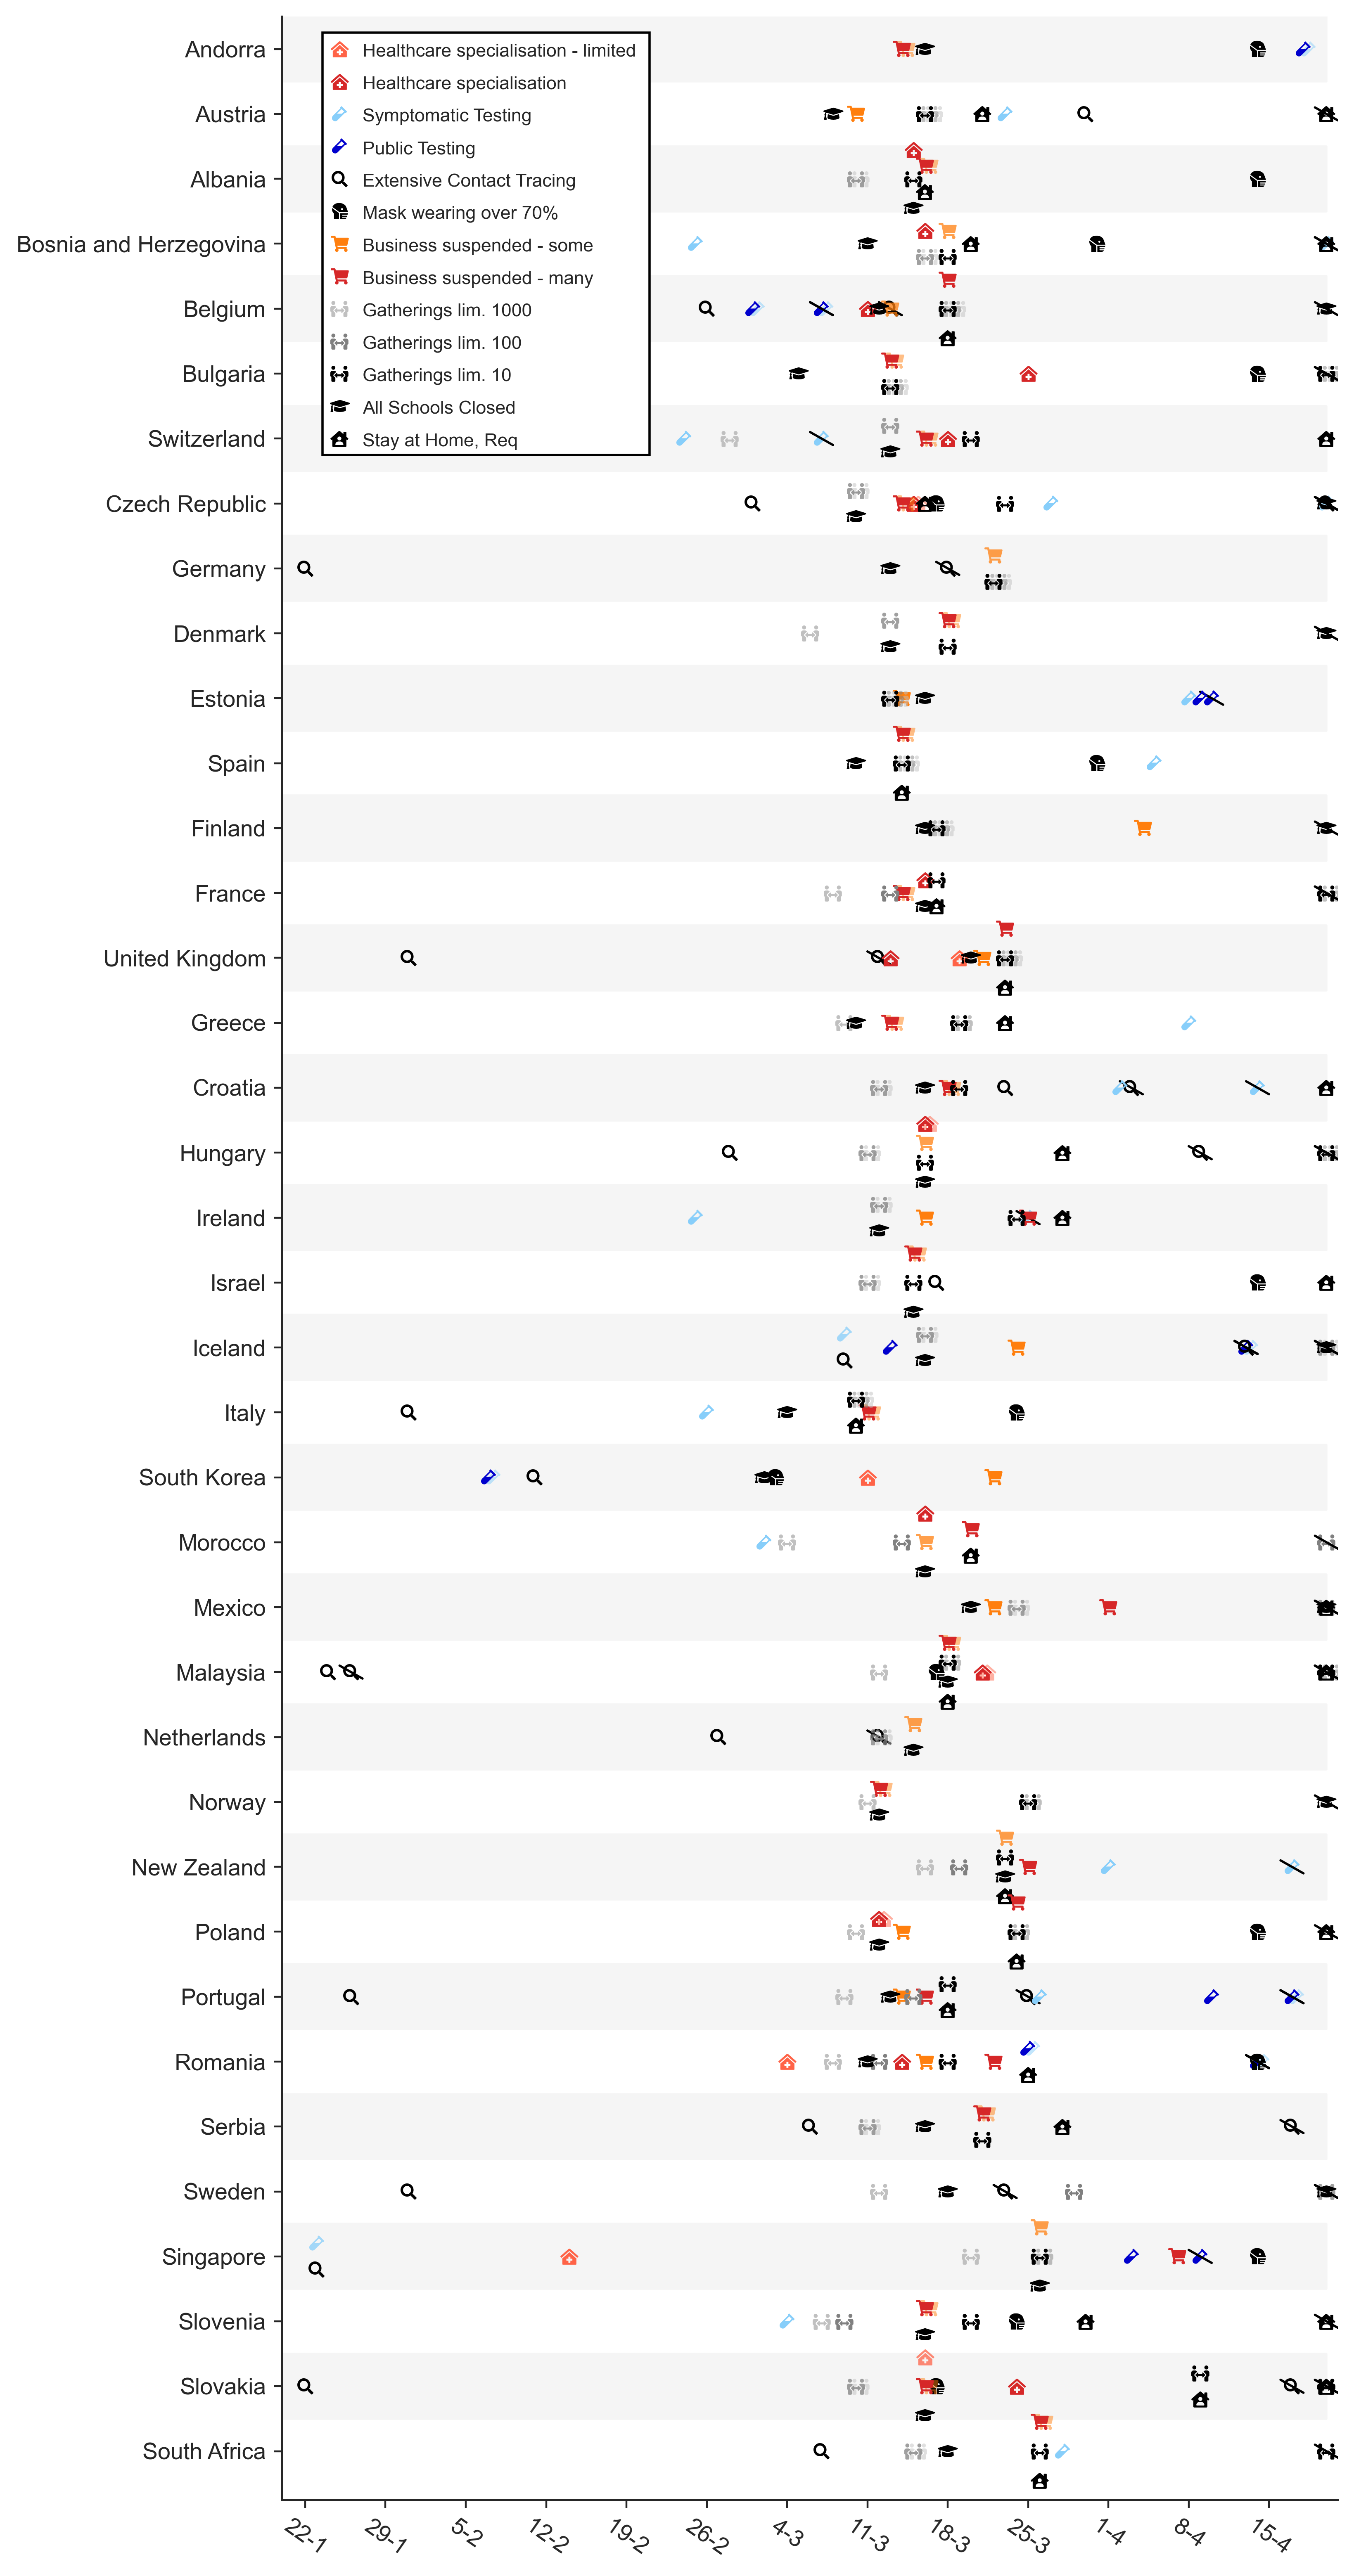

In [176]:
dts = data.Ds
nDs = len(dts)
nRs = len(data.Rs)

x_min = -2
x_max = nDs

spread_small = 0.4
spread_large = 0.9

fig = plt.figure(figsize=(8.3, 15.7), dpi=400)

for height in range(0, nRs, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="whitesmoke")

days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info):
    all_cm_values = ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    a_cm_changes = np.zeros_like(all_cm_values)
    a_cm_changes[:, 1:] = (all_cm_values[:, 1:] - all_cm_values[:, :-1])
    
    all_cm_changes = np.zeros(all_cm_values[0, :].size)
    all_cm_changes[1:] = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    all_cm_changes[0] = np.sum(all_cm_values[:, 0])
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(final_features_ordered):
        cm_values = all_cm_values[indx, :]
        cm_changes = np.zeros(cm_values.size)
        cm_changes[1:] = cm_values[1:] - cm_values[:-1]
        cm_changes[0] = 1 if cm_values[0] == 1 else 0
        
        nz = (np.nonzero(cm_changes)[0]).tolist()
        
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val]
            delta_x = 0
            alpha = 1
            height = region_height
                        
            if all_changes > 1:
                effective_changes = 0
                for cm in range(nCMs):
                    if a_cm_changes[cm, nz_val] == 1:
                        if len(display_with[cm]) > 0:
                            for other_display in display_with[cm]:
                                if a_cm_changes[other_display, nz_val] == 1.0:
                                    break
                                else:
                                    effective_changes += 1
                        else:
                            effective_changes += 1

                if effective_changes > 2:
                    spread = spread_large
                else:
                    spread = spread_small
                
                if d_indx == 7:
                    print(f)
                    print(effective_changes)
                    print(cum_changes[nz_val])
                    print(nz_val)
                    
                if effective_changes > 1:
                    height = (region_height + spread/2) - ((spread/(effective_changes-1)) * cum_changes[nz_val])
                else:
                    height = region_height
                
                if len(display_with[indx]) > 0:
                    for other_display in display_with[indx]:
                        if a_cm_changes[other_display, nz_val] != 0:
                            delta_x += 0.4
                            alpha = 0.5
                    
                    if a_cm_changes[display_with[indx][0], nz_val] == 0:
                        cum_changes[nz_val] += 1
                        alpha = 0.75
                else:
                    # if display with is empty
                    cum_changes[nz_val] += 1
                    
                if d_indx == 7:
                    print(height)
                    print(delta_x)
                
            if cm_changes[nz_val] == 1.0:
                plt.text(nz_val + delta_x, height, plot_style[indx][0], fontproperties=fp2, color=plot_style[indx][1], size=7, alpha=alpha, va='center', ha='center', clip_on=True)
            
            elif cm_changes[nz_val] == -1:
                plt.text(nz_val + delta_x, height,plot_style[indx][0], fontproperties=fp2,  color=plot_style[indx][1], size=7, alpha=alpha, va='center', ha='center', clip_on=True, zorder=1)
                plt.plot([nz_val-1, nz_val+1], [height+0.1, height-0.1], linewidth=1, color="black", zorder=2)
            
            else:
                print(f"Something weird Region {region[0]} NPI: {f} {cm_changes[nz_val-1]}")
        
locs = np.arange(0, nDs, 7)
xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]

import matplotlib.patches as patches

rect = patches.Rectangle((x_min + 3.5, -0.5*len(final_features_ordered) + 0.25), 28.5, 0.5*len(final_features_ordered) , linewidth=1, edgecolor='black', facecolor='white')
plt.gca().add_patch(rect)
for indx, f in enumerate(final_features_ordered):
    plt.text(x_min + 5, -0.5*indx , plot_style[indx][0], fontproperties=fp2,  color=plot_style[indx][1], size=7, va='center', ha='center', clip_on=True, zorder=1)
    plt.text(x_min + 7, -0.5*indx - 0.05, f, size=8, va='center', ha='left')

plt.xticks(locs, xlabels, rotation=-35)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names)), region_names)
plt.ylim([-nRs+0.25, 0.5])
sns.despine()
plt.tight_layout()
plt.savefig("time.pdf")



In [172]:
data.ActiveCMs[8, -2, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])